# Preamble

In [1]:
# Imports
## General
import numpy as np
import pickle as pkl
import json
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import time
import datetime
import sys

## In order to run calculations on AWS GPU, need to explicitly specify CUDA lib directory in the environment variables
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/sagemaker-user/.conda/envs/mlds_gpu"

## Data manipulation and preprocessing
import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler, FunctionTransformer,LabelEncoder, MinMaxScaler,OrdinalEncoder
#import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, MissingIndicator
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy import sparse
from tensorflow.keras.layers import StringLookup, Normalization

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

## Modelling
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Concatenate, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import tensorflow as tf

## Import DeepCTR code
## This is done by cloning the github repository instead of installing with pip. This is because of an incompatibility issue
## with TF 2.14 that I had to manually fix in the DeepCTR code
deepctr_path = '/home/sagemaker-user/drl-ad-personalization/DeepCTR'
if deepctr_path not in sys.path:
    sys.path.append(deepctr_path)

from deepctr.models.fnn import FNN
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.models.pnn import PNN
from deepctr.models.wdl import WDL
from deepctr.models.deepfm import DeepFM
from deepctr.models.autoint import AutoInt
from deepctr.models.fgcnn import FGCNN

2024-08-14 13:11:08.002128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 13:11:08.002176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 13:11:08.002187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 13:11:08.008444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpu_devices = tf.config.list_physical_devices('GPU')
gpu_devices

2024-08-14 13:11:12.225033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 13:11:12.254115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 13:11:12.256090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Introduction


The global digital advertising market is worth approximately \\$602 billion today. Due to the increasing rate of of online participation since the 
COVID-19 pandemic, this number has been rapidly increasing and is expected to reach \\$871 billion by the end of 2027 \citep{RefWorks:emarketer2023digital}.
Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that 
advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content 
shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) 
prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of 
Machine Learning research over the past through years.

Initially, shallow prediction methods such as Logistic Regression, Factorization Machines (Rendel, 2020) and Field-Aware Factorization 
Machines \citep{RefWorks:juan2016field-aware} have been used for CTR prediction. However, these methods have often been shown to be unable to capture the 
higher order feature interactions in the sparse multi-value categorical Ad Marketplace datasets \citep{RefWorks:zhang2021deep}. Since then, Deep Learning methods have been 
shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep 
Learning architechtures for click-through rate prediction.

A number of Deep Learning models have been proposed for CTR prediction, some of which will be explored in this report. Each of these models
outperform their shallow counterparts in terms of predictive ability. In a static environment, these models are able to serve the CTR prediction
function of Ad personalization, but in a dynamic environment, the model must be able to adapt to the changing user preferences. This is where
Reinforcement Learning comes in. Reinforcement Learning is a type of Machine Learning that is used to make a sequence of decisions in an environment
in order to maximize some notion of cumulative reward. In the context of Ad personalization, the environment is composed of the user, the Ad platform
and the advertisments, whereas the reward is the users' engagement with the advertisments and with the Ad platform.


As outlined in the Feasibility secition of my Milestone 3 submission, I have segmented the work over the next few weeks according to the following timeline

![](figures/timeline.png)

Below I proceed by structuring my response according to the following sections
- General Background to Deep CTR and Deep Renforcement Learning
- Data exploration, preprocessing and environment setup
- Model Introduction, Replication and Experimentation

Please note that this notebook illustrates my current work in progress, and certain sections are far from finished. I have also concurrently begun sections of my final write up using the LaTeX template provided. This is available along with the rest of my code in the following Github repository: https://github.com/martinbatek/drl-ad-personalization

# Background

## Deep CTR Prediction

In their respective surveys on the use of Deep Learning methods for CTR prediction, (Gu, 2021) and (Zhang et al., 2021) outline the 
problem of CTR prediction as one that essentially boils down to a binary (click/no-click) classification problem utilizing user/ad-view event level 
online session records. The goal of CTR prediction is to predict the probability of a user clicking on an advertisment given the information available
about the user, advertisment and the context in which the advertisement is shown. Suppose that $\mathbf{x} \in \mathbb{R}^n$
is a vector of features that describes the user, ad and platform for a given instance, and
$y \in \{0, 1\}$ is the binary label indicating whether the user clicked on the ad or not. The goal of CTR prediction is to learn a function
$f: \mathbb{R}^n \rightarrow (0,1)$ such that:

$$
f(\mathbf{x}) = \mathbb{P}(y = 1 | \mathbf{x}) = \mathbb{P}(\text{click}| \mathbf{x})
$$

In other words, for a given set of features $\mathbf{x}$, the model should output the probability that the user will click on the ad.
A defining characteristic for this type of data is that many of the features are multi-value categories with a high degree of of cardinality \citep{RefWorks:he2017neural}. 
This in turn means that the ad marketplace datasets used for CTR predictions can be extremely sparse, which increases the difficulty of the classification problem at 
hand \citep{RefWorks:gu2021ad}.

A key requirement for CTR modelling is therefore working out which of the many sparse features and feature 
interactions (combinations of two or more features) are significant for determining the correct prediction 
(Gu, 2021). Factorization Machines (Rendle, 2010) and Field-aware Factorization Machines (Juan et al., 2016) 
were popularized shallow modelling methods that explicitly account for first order interactions between features. 
However, these techniques do not capture higher order interactions (combinations of three or more features) and 
have thus been known to perform poorly in scenarios with highly sparse data (Zhang et al., 2021). Since 2015 the 
research cummunity has been increasingly turning to Deep Learning techniques to enhance prior CTR prediction 
techniques (such as in the case of DeepFM (Guo et al., 2017)), as well as to develop novel approaches. Neural based 
network models excel at simulataneoulsy extracting high-order and low-order feature interations virtue to the use 
of pooling layers, multiple hidden layers and activation units (Gu, 2021). Due the aforementioned importance of 
feature interation modelling, a number of Feature Interaction Operator layers have been developed to explicitly 
capture the key combinations of features. These layers are then typically incorporated with a supplimentary Deep 
Neural Network in a single or dual tower architecture, as shown in the Figure below:

![DNN_Architecture](figures/single_dual_dnn.png)


Feature Interaction Operators can be categorized as either Product Operators, Convolutional Operators or Attention Operators. Product Operators such as the Product-based Neural Network (PNN) (Qu et al., 2016), Neural Factorization Machines (NFM) (He & Chua, 2017), Deep and Cross Network (Wang et al., 2017) and Gated Deep Cross Network (GDCN) (Wang, F. et al., 2023) introduce a product layer between the categorical feature embedding layer and the rest of the neural network in order to explicitly model the important feature interactions. Convolutional Operators such as the Convolutional Click Prediction Model (CCPM) (Liu et al., 2015) utilized convolution, pooling and non-linear activation in order to calculate arbitrary-order interactions. Finally, Attention Operators such as Attentional Factorization Machines (AFM) (Xiao et al., 2017), AutoInt (Song et al., 2019) and Interpretable CTR prediction model with Hierarchical Attention (InterHAt) (Li et al., 2020) utilize the attention mechanism to enable different feature interactions to contribute differently to the prediction.

## Deep Reinforcement Learning

In their survey, (Wang, X. et al., 2024) describe how deep reinforcement learning combines the aforementioned feature extraction capabilities of DNN’s with the decision-making capability of reinforcement learning, which aims to learn an optimal state-action policy which maximizes the expected reward gained in a given environment. In the context of recommendation systems, a significant amount of research has been dedicated to formulating the recommendation problem as a Contextual Multi-Armed Bandit (MAB) problem setting, where the context consists of user, site and item features (Bouneffouf, Bouzeghoub & Gancarski, 2012; Li, L. et al., 2010; Zeng et al., 2016). However, a shortcoming for the MAB approach is that it does not explicitly model the future expected reward for the policy, which may be detrimental in the longer term (Zheng et al., 2018). Markov Decision Process (MDP) models solve for this issue by modelling the state-action progression as a Markov Process, allowing for the stochastic valuation of the future potential rewards for a given recommendation policy (Lu & Yang, 2016; Mahmood & Ricci, 2007). DRN (Zheng et al., 2018) is a MDP framework that leverages a Deep Neural Network to approximate the expected total user response for each recommendation at each state. The two major advantages of DRN are firstly that it is composed on the basis of a continuous state and action representation, meaning that it can be scaled to large and sparse datasets, and secondly that the proposed reward function consists of both the immediate reward (user click) as well as the future expected reward (long term user engagement), thereby allowing for better recommendations over a user’s lifetime.

# Data Exploration, Caching, Preprocessing pipeline

## Data Exploration

TBD - Include data Exploration sections from Milestone 2

## Load benchmark datasets as tf.datasets

### KDD12

In [3]:
# Load the kdd12_train dataset
kdd12_train = tf.data.experimental.make_csv_dataset(
    "data/kdd12/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    #label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

2024-08-14 13:11:12.275793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 13:11:12.277469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 13:11:12.279265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# Load the kdd12_train dataset
kdd12_val = tf.data.experimental.make_csv_dataset(
    "data/kdd12/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    #label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [5]:
# Define function to derive ctr and split this as the target
@tf.function
def kdd12_target(element):
    features = element.copy()
    click = features.pop(key='click')
    impression = features.pop(key="impression")
    ctr_label = tf.math.divide(click,impression)
    return features, ctr_label

In [6]:
# Apply to datasets
kdd12_train = kdd12_train.map(kdd12_target)
kdd12_val = kdd12_val.map(kdd12_target)

In [7]:
kdd12_train.element_spec

(OrderedDict([('displayurl',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('adid', TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('advertiserid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('depth', TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
              ('position',
               TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
              ('keywordid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('titleid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('descriptionid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('queryid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('userid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None))]),
 TensorSpec(shape=(None,), dtype=tf.float64, name

In [8]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in kdd12_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in kdd12_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.147702
Time taken 256 records val: 0:00:00.125355


### Avazu

In [9]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]
avazu_train = tf.data.experimental.make_csv_dataset(
    "data/avazu/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [10]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]

# Load the Avazu train dataset
avazu_val = tf.data.experimental.make_csv_dataset(
    "data/avazu/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [11]:
# Drop ID variable
def drop_id(features, label):
    out_features = features.copy()
    del out_features['id']
    return out_features, label

In [12]:
avazu_train = avazu_train.map(drop_id)
avazu_val = avazu_val.map(drop_id)

In [13]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in avazu_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in avazu_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.175928
Time taken 256 records val: 0:00:00.171727


### Criteo

In [14]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_train = tf.data.experimental.make_csv_dataset(
    "data/criteo/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [15]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_val = tf.data.experimental.make_csv_dataset(
    "data/criteo/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

In [16]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in criteo_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in criteo_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.234623
Time taken 256 records val: 0:00:00.437494


## Preprocessing

Below I construct the preprocessing pipeline for the tensorflow datasets on the basis of the exploration functions above. I proceed by:

- Enconding the sparse catecorically features using the Ordinal Encoders specified above.
- Standardizing the numerical features unsing the Scalers and Transformer specified above.
- Generating the feature columns, as specified in the [DeepCTR Quickstart Guide](https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html#step-3-generate-feature-columns)

In [17]:
## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'C1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'C14',
    'C15',
    'C16',
    'C17',
    'C18',
    'C19',
    'C20',
    'C21'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]
criteo_categorical_columns = [f'cat_{i}' for i in np.arange(1,27)]

### Categorical Variable Encoding

In [18]:
# Import categorical feature mappings and define stringloohup objects for each dataset
kdd12_stringlookups = {}
kdd12_vocab_lengths = {}
for field in kdd12_categorical_columns:
    df = pd.read_csv(f'./data/kdd12/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    kdd12_stringlookups.update({field:lookup})
    kdd12_vocab_lengths.update({field:len(vocab)+1})

avazu_stringlookups = {}
avazu_vocab_lengths = {}
for field in avazu_categorical_columns:
    df = pd.read_csv(f'./data/avazu/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    avazu_stringlookups.update({field:lookup})
    avazu_vocab_lengths.update({field:len(vocab)+1})

criteo_stringlookups = {}
criteo_vocab_lengths = {}
for field in criteo_categorical_columns:
    df = pd.read_csv(f'./data/criteo/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    criteo_stringlookups.update({field:lookup})
    criteo_vocab_lengths.update({field:len(vocab)+1})

In [19]:
# Define categorical encoding function
@tf.function
def kdd12_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in kdd12_categorical_columns:
        lookup = kdd12_stringlookups[f]
        out_features[f.lower()] = lookup(features[f.lower()])
    return out_features, label

@tf.function
def avazu_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in avazu_categorical_columns:
        lookup = avazu_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

@tf.function
def criteo_categorical_encoding(features,label):
    # Create copy of features
    out_features = features.copy()
    # Iteratively map the categorical feature columns using the corresponding Lookup layer
    for f in criteo_categorical_columns:
        lookup = criteo_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

In [20]:
# Apply mapping over each dataset

kdd12_train_encoded = kdd12_train.map(kdd12_categorical_encoding)
avazu_train_encoded = avazu_train.map(avazu_categorical_encoding)
criteo_train_encoded = criteo_train.map(criteo_categorical_encoding)

kdd12_val_encoded = kdd12_val.map(kdd12_categorical_encoding)
avazu_val_encoded = avazu_val.map(avazu_categorical_encoding)
criteo_val_encoded = criteo_val.map(criteo_categorical_encoding)

In [21]:
# Print time taken to iterate through 256 records
stage = "encoded"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train encoded: 0:00:00.125577
Time taken 256 records kdd12 val encoded: 0:00:00.127110
Time taken 256 records avazu train encoded: 0:00:00.125130
Time taken 256 records avazu val encoded: 0:00:00.127836
Time taken 256 records criteo train encoded: 0:00:00.125363
Time taken 256 records criteo val encoded: 0:00:00.126610


### Numerical Variable Scaling

In [22]:
# Define numerical feature columns
kdd12_numerical_columns = [
    'Depth',
    'Position'
]

avazu_numerical_columns = [
    'hour'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]

In [23]:
# Extract scaler dicts for all datasets
dist_stats = pd.read_csv('./data/kdd12/means_variances.csv')
kdd12_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    kdd12_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/avazu/means_variances.csv')
avazu_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    avazu_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/criteo/means_variances.csv')
criteo_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    criteo_scalers.update({field:scaler})

In [24]:
# Define scaler functions for all datasets

@tf.function
def kdd12_numerical_scaling(features,label):
    out_features = features.copy()
    for f in kdd12_numerical_columns:
        scaler = kdd12_scalers[f]
        out_features[f.lower()] = scaler(features[f.lower()])
    return out_features, label

@tf.function
def avazu_numerical_scaling(features,label):
    out_features = features.copy()
    for f in avazu_numerical_columns:
        scaler = avazu_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

@tf.function
def criteo_numerical_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        scaler = criteo_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

In [25]:
# Apply the numerical scaling to all datasets
kdd12_train_scaled = kdd12_train_encoded.map(kdd12_numerical_scaling)
avazu_train_scaled = avazu_train_encoded.map(avazu_numerical_scaling)
criteo_train_scaled = criteo_train_encoded.map(criteo_numerical_scaling)

kdd12_val_scaled = kdd12_val_encoded.map(kdd12_numerical_scaling)
avazu_val_scaled = avazu_val_encoded.map(avazu_numerical_scaling)
criteo_val_scaled = criteo_val_encoded.map(criteo_numerical_scaling)

In [26]:
# Print time taken to iterate through 256 records
stage = "scaled"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train scaled: 0:00:00.126244
Time taken 256 records kdd12 val scaled: 0:00:00.128254
Time taken 256 records avazu train scaled: 0:00:00.125322
Time taken 256 records avazu val scaled: 0:00:00.126079
Time taken 256 records criteo train scaled: 0:00:00.125688
Time taken 256 records criteo val scaled: 0:00:00.125036


In [27]:
# Print the element specs
print('KDD12:')
print(kdd12_train_scaled.element_spec)
print()
print('Avazu:')
print(avazu_train_scaled.element_spec)
print()
print('Criteo:')
print(criteo_train_scaled.element_spec)

KDD12:
(OrderedDict([('displayurl', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('adid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('advertiserid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('depth', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('position', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('keywordid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('titleid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('descriptionid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('queryid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('userid', TensorSpec(shape=(None,), dtype=tf.int64, name=None))]), TensorSpec(shape=(None,), dtype=tf.float64, name=None))

Avazu:
(OrderedDict([('hour', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('C1', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('banner_pos', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('site_id', Tens

In [28]:
# Apply log transformation to criteo datase

@tf.function
def criteo_log_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        x = features[f]
        out_features[f] = tf.where(x>2,tf.math.square(tf.math.log(x)),x)
    return out_features, label

In [29]:
criteo_train_scaled = criteo_train_scaled.map(criteo_log_scaling)
criteo_val_scaled = criteo_val_scaled.map(criteo_log_scaling)

In [30]:
# Print time taken to iterate through 256 records
stage = "scaled"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train scaled: 0:00:00.127167
Time taken 256 records kdd12 val scaled: 0:00:00.126479
Time taken 256 records avazu train scaled: 0:00:00.127048
Time taken 256 records avazu val scaled: 0:00:00.125336
Time taken 256 records criteo train scaled: 0:00:00.125703
Time taken 256 records criteo val scaled: 0:00:00.124966


In [31]:
# Define model inputs
kdd12_train_model_input = kdd12_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)
avazu_train_model_input = avazu_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)
criteo_train_model_input = criteo_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)

kdd12_val_model_input = kdd12_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)
avazu_val_model_input = avazu_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)
criteo_val_model_input = criteo_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)

In [32]:
# Print time taken to iterate through 1 batch
stage = "model_input"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(1):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} batch {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 1 batch kdd12 train model_input: 0:00:00.047939
Time taken 1 batch kdd12 val model_input: 0:00:00.047686
Time taken 1 batch avazu train model_input: 0:00:00.047668
Time taken 1 batch avazu val model_input: 0:00:00.046735
Time taken 1 batch criteo train model_input: 0:00:00.047453
Time taken 1 batch criteo val model_input: 0:00:00.047874


In [33]:
# One-Hot encode the categorical columns
@tf.function
def one_hot_categorical(features, labels, categorical_columns):
    features_out = features.copy()
    for field in categorical_columns:
        features_out[field] = tf.squeeze(tf.one_hot(features[field],depth=50,dtype=tf.float32),axis=-2)
    return features_out, labels

In [34]:
# One-hot encode the datasets
kdd12_categorical_lower = [x.lower() for x in kdd12_categorical_columns]

kdd12_train_ohe = kdd12_train_model_input.map(lambda x, y: one_hot_categorical(x,y,kdd12_categorical_lower))
kdd12_val_ohe = kdd12_val_model_input.map(lambda x, y: one_hot_categorical(x,y,kdd12_categorical_lower))
avazu_train_ohe = avazu_train_model_input.map(lambda x, y: one_hot_categorical(x,y,avazu_categorical_columns))
avazu_val_ohe = avazu_val_model_input.map(lambda x, y: one_hot_categorical(x,y,avazu_categorical_columns))
criteo_train_ohe = criteo_train_model_input.map(lambda x, y: one_hot_categorical(x,y,criteo_categorical_columns))
criteo_val_ohe = criteo_val_model_input.map(lambda x, y: one_hot_categorical(x,y,criteo_categorical_columns))

In [35]:
# Define function to concatinate all features together
@tf.function
def combine(features, labels):
    columns = list(features.keys())
    out_cols = []
    for field in columns:
        out_cols.append(features[field])
    features_out = tf.concat(out_cols,axis=-1)
    return features_out, labels

In [36]:
kdd12_train_ohe = kdd12_train_ohe.map(combine)
kdd12_val_ohe = kdd12_val_ohe.map(combine)
avazu_train_ohe = avazu_train_ohe.map(combine)
avazu_val_ohe = avazu_val_ohe.map(combine)
criteo_train_ohe = criteo_train_ohe.map(combine)
criteo_val_ohe = criteo_val_ohe.map(combine)

In [37]:
# Print time taken to iterate through 1 batch
stage = "ohe"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(1):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} batch {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 1 batch kdd12 train ohe: 0:00:00.048780
Time taken 1 batch kdd12 val ohe: 0:00:00.047123
Time taken 1 batch avazu train ohe: 0:00:00.046826
Time taken 1 batch avazu val ohe: 0:00:00.047578
Time taken 1 batch criteo train ohe: 0:00:00.047470
Time taken 1 batch criteo val ohe: 0:00:00.048203


In [38]:
# Calculate the input shapes for each of the datasets
kdd12_ohe_shape = (len(kdd12_categorical_columns)*50 + len(kdd12_numerical_columns),)
avazu_ohe_shape = (len(avazu_categorical_columns)*50 + len(avazu_numerical_columns),)
criteo_ohe_shape = (len(criteo_categorical_columns)*50 + len(criteo_numerical_columns),)

### Define Feature columns

In [39]:
## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat.lower(), vocabulary_size=kdd12_vocab_lengths[feat], embedding_dim=4) for feat in kdd12_categorical_columns]\
+ [DenseFeat(feat.lower(),1) for feat in kdd12_numerical_columns]
avazu_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=avazu_vocab_lengths[feat], embedding_dim=4) for feat in avazu_categorical_columns]\
+ [DenseFeat(feat,1) for feat in avazu_numerical_columns]
criteo_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=criteo_vocab_lengths[feat], embedding_dim=4) for feat in criteo_categorical_columns]\
+ [DenseFeat(feat,1) for feat in criteo_numerical_columns]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns

avazu_dnn_feature_columns = avazu_fixlen_feature_columns
avazu_linear_feature_columns = avazu_fixlen_feature_columns

criteo_dnn_feature_columns = criteo_fixlen_feature_columns
criteo_linear_feature_columns = criteo_fixlen_feature_columns

# Model Replication and Experimentation

In [40]:
# Create the model checkpoint directories if they do not exist
for model in ['lr','fm','fnn','pnn','wdl','dfm','autoint','fgcnn']:
    for dataset in ['kdd12','avazu','criteo']:
        if not os.path.exists(f'./models/{model}/{dataset}'):
            os.makedirs(f'./models/{model}/{dataset}')

In [41]:
# Define the early stopping callback
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Define the precision, recall and auc metrics
precision = tf.keras.metrics.Precision(thresholds=0.5,name='precision')
recall = tf.keras.metrics.Recall(thresholds=0.5,name='recall')
auc = tf.keras.metrics.AUC(name='auc')

## Shallow Models

In order assess the effectiveness of Deep Learning methods for CTR prediction, it makes sense to attain a model score using more traditional model architectures in order to use these as a comparison. (Zhang et al., 2021) briefly discuss the how CTR applications steadily progressed from Shallow to Deep models. The most basic shallow model for the CTR binary classification task is Logistic Regression (Richardson, Dominowska & Ragno, 2007) which benefits from “high efficiency and ease for fast deployment” (Zhang et al., 2021). However, as it became apparent that identifying key feature interactions is crucial for the CTR prediction task, architectures that explicitly capture these interactions such as the Factorization Machine (Juan et al., 2016; Rendle, 2010) became increasingly popular in the domain.

In order to attain representitive results from beyond the realm of deep learning, below I evaluate two of the most poplarly used shallow models for CTR prediction:

- [Logistic regression](https://www.tensorflow.org/guide/core/logistic_regression_core)
- Factorization machines

### Logistic Regression

In logistic regression, we use the logistic (a.k.a. sigmoid) function as our function $f_\theta$, i.e:
$$
\mathcal{P}\left(\mathrm{Click}\right)=\frac{e^{\beta_0+\sum_{i}{\beta_ix_i}}}{1+e^{\beta_0+\sum_{i}{\beta_ix_i}}}
$$
(James et al., 2021) show that the equation above can be rearranged as follows:
$$
\beta_0+\sum_{i}{\beta_ix_i}=log{\left(\frac{\mathcal{P}\left(\mathrm{Click}\right)}{1-\mathcal{P}\left(\mathrm{Click}\right)}\right)}
$$
Logistic regression therefore effectively amounts to fitting a linear regression function to the log odds of a that there is a click for a given instance, parameterized by $\theta=\left(\beta_0,\beta_1,\ldots,\beta_n\right)$. (Richardson, Dominowska & Ragno, 2007) showed that it is possible to fit a logistic regression model on search advertising data in order to provide accurate click-through rate predictions for each ad, and even demonstrated that the used of this model “improves convergence and performance on the advertising system”. As stated previously, a major benefit of the logistic model over all of the others mentioned here is that since it works on the basis of a simple linear combination of the given features, it is the simplest model to fit and deploy. However, a major shortcoming of this model is the fact that it does not account for feature interactions, and it therefore fails to pick up on discriminating patterns given by the cross-features in the highly sparse categorical ad marketplace data (Zhang et al., 2021).


Below, I replicate the Logistic regression model in Tensorflow by defining a `Sequential` model class with a single `Dense` layer with sigmoid activation. The Dense layer simply implements the linear combination $\beta_0+\sum_{i}{\beta_ix_i}$ from above, before passing the result through the sigmoid function $\sigma(x) = \frac{e^x}{1+e^x}$.

In [46]:
# Define the CSVLogger callbacks
kdd12_lr_csvLogger = CSVLogger('logs/kdd12_lr.csv')
avazu_lr_csvLogger = CSVLogger('logs/avazu_lr.csv')
criteo_lr_csvLogger = CSVLogger('logs/criteo_lr.csv')

In [47]:
# Define the model saving checkpoints
# Define the model saving checkpoints
kdd12_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/kdd12/kdd12_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/avazu/avazu_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/criteo/criteo_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [48]:
# Define a single dense layer sequential model using sigmoid activation function

kdd12_lr_model = Sequential([
    Input(shape=kdd12_ohe_shape),
    Dense(1,activation='sigmoid')
])
avazu_lr_model = Sequential([
    Input(shape=avazu_ohe_shape),
    Dense(1,activation='sigmoid')
])
criteo_lr_model = Sequential([
    Input(shape=criteo_ohe_shape),
    Dense(1,activation='sigmoid')
])

In [49]:
# Compile the models
sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)


kdd12_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
avazu_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
criteo_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)

In [ ]:
# Fit the models to the datasets

kdd12_lr_model.fit(
    kdd12_train_ohe,
    validation_data=kdd12_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[kdd12_lr_csvLogger, kdd12_lr_modelCheckpoint, earlystopping]
)
avazu_lr_model.fit(
    avazu_train_ohe,
    validation_data=avazu_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[avazu_lr_csvLogger, avazu_lr_modelCheckpoint, earlystopping]
)

criteo_lr_model.fit(
    criteo_train_ohe,
    validation_data=criteo_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[criteo_lr_csvLogger, criteo_lr_modelCheckpoint, earlystopping]
)

Epoch 1/15


2024-08-07 17:59:27.894064: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


    615/Unknown - 20s 29ms/step - loss: 0.3627 - binary_crossentropy: 0.3627 - binary_accuracy: 0.9361 - precision: 0.0297 - recall: 0.0133 - auc: 0.5071

2024-08-07 17:59:47.018672: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2418447019255897644
2024-08-07 17:59:47.018735: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4856273115428181782
2024-08-07 17:59:47.018755: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 18070302761286639741
2024-08-07 17:59:47.018776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9472769288101845655


615/615 [==============================] - 25s 37ms/step - loss: 0.3627 - binary_crossentropy: 0.3627 - binary_accuracy: 0.9361 - precision: 0.0297 - recall: 0.0133 - auc: 0.5071 - val_loss: 0.2345 - val_binary_crossentropy: 0.2345 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5481
Epoch 2/15
  1/615 [..............................] - ETA: 21s - loss: 0.2282 - binary_crossentropy: 0.2282 - binary_accuracy: 0.9531 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7106

2024-08-07 17:59:51.920194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17226360151746806855
2024-08-07 17:59:51.920261: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15397434983285586796


615/615 [==============================] - 23s 37ms/step - loss: 0.2048 - binary_crossentropy: 0.2048 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5482 - val_loss: 0.1875 - val_binary_crossentropy: 0.1875 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5649
Epoch 3/15
615/615 [==============================] - 23s 37ms/step - loss: 0.1793 - binary_crossentropy: 0.1793 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5647 - val_loss: 0.1744 - val_binary_crossentropy: 0.1744 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5721
Epoch 4/15
615/615 [==============================] - 23s 37ms/step - loss: 0.1709 - binary_crossentropy: 0.1709 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5728 - val_loss: 0.1692 - val_binary_crossentropy: 0.1692 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+0

2024-08-07 18:05:35.460797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17191053669887100576
2024-08-07 18:05:35.460871: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8208892640582103125
2024-08-07 18:05:35.460894: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9472769288101845655


615/615 [==============================] - 29s 47ms/step - loss: 0.4590 - binary_crossentropy: 0.4590 - binary_accuracy: 0.8236 - precision: 0.1740 - recall: 0.0105 - auc: 0.6388 - val_loss: 0.4380 - val_binary_crossentropy: 0.4380 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6185
Epoch 2/15


2024-08-07 18:05:41.669397: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4517513544554614791
2024-08-07 18:05:41.669452: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17226360151746806855
2024-08-07 18:05:41.669475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2418447019255897644


615/615 [==============================] - 29s 47ms/step - loss: 0.4378 - binary_crossentropy: 0.4378 - binary_accuracy: 0.8307 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6355 - val_loss: 0.4333 - val_binary_crossentropy: 0.4333 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6376
Epoch 3/15
615/615 [==============================] - 29s 47ms/step - loss: 0.4340 - binary_crossentropy: 0.4340 - binary_accuracy: 0.8307 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6501 - val_loss: 0.4306 - val_binary_crossentropy: 0.4306 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6478
Epoch 4/15
615/615 [==============================] - 29s 47ms/step - loss: 0.4316 - binary_crossentropy: 0.4316 - binary_accuracy: 0.8307 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6585 - val_loss: 0.4287 - val_binary_crossentropy: 0.4287 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+0

2024-08-07 18:14:25.445808: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8208892640582103125
2024-08-07 18:14:25.445868: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9472769288101845655
2024-08-07 18:14:25.445902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17191053669887100576


615/615 [==============================] - 172s 280ms/step - loss: 0.6040 - binary_crossentropy: 0.6040 - binary_accuracy: 0.6833 - precision: 0.4610 - recall: 0.0331 - auc: 0.6574 - val_loss: 0.5890 - val_binary_crossentropy: 0.5890 - val_binary_accuracy: 0.6903 - val_precision: 0.6132 - val_recall: 0.0649 - val_auc: 0.6747


2024-08-07 18:15:20.355480: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4517513544554614791
2024-08-07 18:15:20.355534: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17226360151746806855
2024-08-07 18:15:20.355558: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2418447019255897644


Epoch 2/15
615/615 [==============================] - 170s 277ms/step - loss: 0.5823 - binary_crossentropy: 0.5823 - binary_accuracy: 0.6967 - precision: 0.6127 - recall: 0.0979 - auc: 0.6819 - val_loss: 0.5810 - val_binary_crossentropy: 0.5810 - val_binary_accuracy: 0.7009 - val_precision: 0.6398 - val_recall: 0.1317 - val_auc: 0.6848
Epoch 3/15
615/615 [==============================] - 170s 277ms/step - loss: 0.5763 - binary_crossentropy: 0.5763 - binary_accuracy: 0.7035 - precision: 0.6255 - recall: 0.1437 - auc: 0.6899 - val_loss: 0.5773 - val_binary_crossentropy: 0.5773 - val_binary_accuracy: 0.7042 - val_precision: 0.6326 - val_recall: 0.1616 - val_auc: 0.6897
Epoch 4/15
615/615 [==============================] - 170s 277ms/step - loss: 0.5730 - binary_crossentropy: 0.5730 - binary_accuracy: 0.7070 - precision: 0.6267 - recall: 0.1704 - auc: 0.6945 - val_loss: 0.5751 - val_binary_crossentropy: 0.5751 - val_binary_accuracy: 0.7059 - val_precision: 0.6272 - val_recall: 0.1808 - va

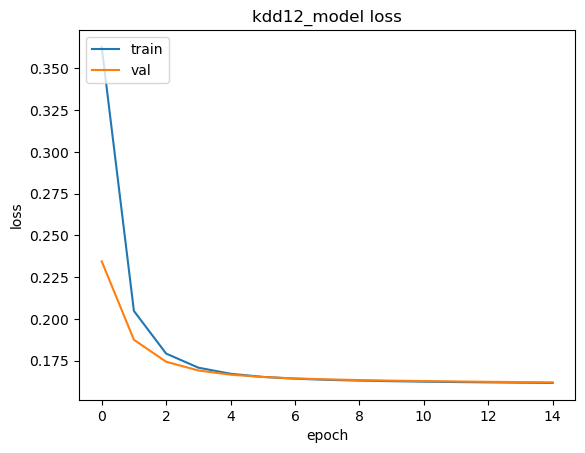

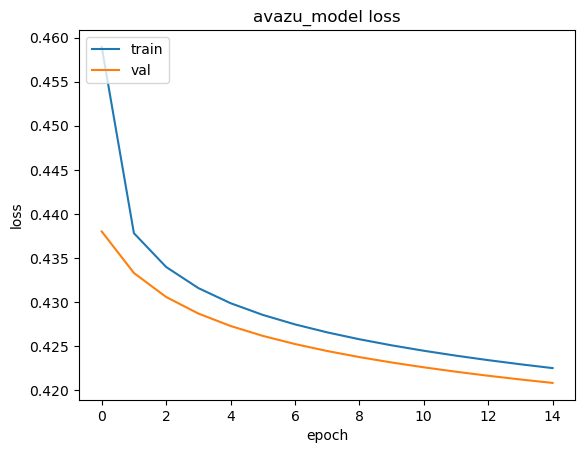

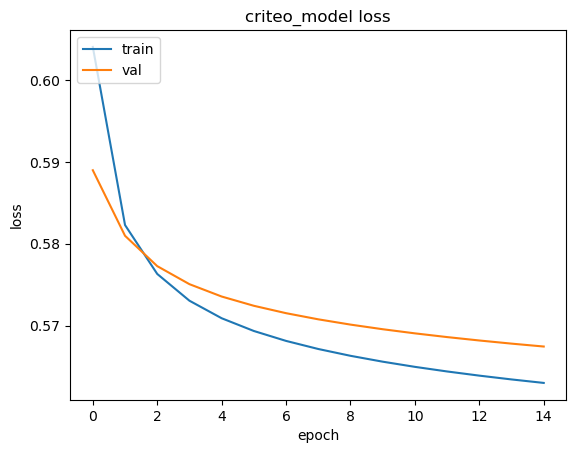

In [ ]:
# Plot the training and validation losses for each epoch
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_lr.csv')
avazu_history = pd.read_csv('logs/avazu_lr.csv')
criteo_history = pd.read_csv('logs/criteo_lr.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Factorization Machine

Factorization Machines were first introduced in \citep{RefWorks:rendle2010factorization} as
a model class that ``combines the advantages of Support Vector Machines (SVM) with factorization models''.
The model is able to capture the second order feature interactions in the data, which is a key advantage over
Logistic Regression. The model is defined as follows:

$$
\hat{y}(\mathbf{x}) = w_0 + \sum_{i=1}^{n} w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \mathbf{v}_i, \mathbf{v}_j \rangle x_i x_j
$$

where $w_0$ is the bias term, $w_i$ are the weights for the $i$-th feature, $\mathbf{v}_i$ are the latent vectors for the $i$-th feature.
Rendel (2020) shows that the learned biases and weights of the FM model can be
computed in linear time, ``and can be learned efficiently by gradient descent methods'', such as Stochastic Gradient Descent (SGD).

In the code below, I replicate the FM model by first creating a custom `tf.keras.layers.Layer` class that carries out the
forward calculation above. The trainable weights of the layer are then optimized using Stochastic Gradient Descent with 
`learning_rate=0.01`.

In [ ]:
# Define custom FactorizationMachine layer
class FactorizationMachine(tf.keras.layers.Layer):
    def __init__(self, k, name="FM_layer"):
        super(FactorizationMachine, self).__init__(name=name)
        self.k = k

    def build(self, input_shape):
        self.w0 = self.add_weight("bias", shape=(1,), initializer=tf.keras.initializers.GlorotNormal())
        self.W = self.add_weight("weights", shape=(input_shape[-1],), initializer=tf.keras.initializers.GlorotNormal())
        self.V = self.add_weight("interaction_factors", shape=(self.k, input_shape[-1]), initializer=tf.keras.initializers.GlorotNormal())

    def call(self, inputs):
        linear_terms = tf.add(
            self.w0,
            tf.reduce_sum(
                tf.multiply(self.W, inputs),
                axis=1,
                keepdims=True
            )
        )
        interaction_terms = tf.multiply(
            0.5,
            tf.reduce_sum(
                tf.math.subtract(
                    tf.pow(tf.matmul(inputs, tf.transpose(self.V)), 2),
                    tf.matmul(tf.pow(inputs, 2), tf.transpose(tf.pow(self.V, 2)))
                ),
                axis=1, 
                keepdims=True
            )
        )
        return tf.add(linear_terms,interaction_terms)
        
    # Have to overwite the get_config method to save the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({'k':self.k})
        return config

In [ ]:
# Create sequential Factorization Machine Models
kdd12_fm_model = Sequential([
    Input(shape=kdd12_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])
avazu_fm_model = Sequential([
    Input(shape=avazu_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])
criteo_fm_model = Sequential([
    Input(shape=criteo_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])

In [ ]:
# Define the CSVLogger callbacks
kdd12_fm_csvLogger = CSVLogger('logs/kdd12_fm.csv')
avazu_fm_csvLogger = CSVLogger('logs/avazu_fm.csv')
criteo_fm_csvLogger = CSVLogger('logs/criteo_fm.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/kdd12/kdd12_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/avazu/avazu_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/criteo/criteo_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Compile the models
sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)


kdd12_fm_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
avazu_fm_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
criteo_fm_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)

In [ ]:
# Fit the models
kdd12_fm_model.fit(
    kdd12_train_ohe,
    validation_data = kdd12_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[kdd12_fm_csvLogger, kdd12_fm_modelCheckpoint, earlystopping]
)
'''
avazu_fm_model.fit(
    avazu_train_ohe,
    validation_data = avazu_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[avazu_fm_csvLogger, avazu_fm_modelCheckpoint, earlystopping]
)
criteo_fm_model.fit(
    criteo_train_ohe,
    validation_data = criteo_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[criteo_fm_csvLogger, criteo_fm_modelCheckpoint, earlystopping]
)
'''

Epoch 1/15
    614/Unknown - 19s 29ms/step - loss: 0.2152 - binary_crossentropy: 0.2152 - binary_accuracy: 0.9551 - precision: 0.6283 - recall: 0.1519 - auc: 0.7539

2024-08-07 18:55:33.827580: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4142698983276422083
2024-08-07 18:55:33.827660: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15418716029561191044


615/615 [==============================] - 23s 37ms/step - loss: 0.2151 - binary_crossentropy: 0.2151 - binary_accuracy: 0.9551 - precision: 0.6283 - recall: 0.1519 - auc: 0.7539 - val_loss: 0.1900 - val_binary_crossentropy: 0.1900 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5699
Epoch 2/15
  1/615 [..............................] - ETA: 21s - loss: 0.1851 - binary_crossentropy: 0.1851 - binary_accuracy: 0.9531 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7551

2024-08-07 18:55:38.717287: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9472769288101845655
2024-08-07 18:55:38.717368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2418447019255897644


615/615 [==============================] - 23s 37ms/step - loss: 0.1798 - binary_crossentropy: 0.1798 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5706 - val_loss: 0.1738 - val_binary_crossentropy: 0.1738 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5878
Epoch 3/15
615/615 [==============================] - 23s 37ms/step - loss: 0.1698 - binary_crossentropy: 0.1698 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5895 - val_loss: 0.1680 - val_binary_crossentropy: 0.1680 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5990
Epoch 4/15
615/615 [==============================] - 23s 37ms/step - loss: 0.1659 - binary_crossentropy: 0.1659 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5991 - val_loss: 0.1654 - val_binary_crossentropy: 0.1654 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+0

'\navazu_fm_model.fit(\n    avazu_train_ohe,\n    validation_data = avazu_val_ohe,\n    batch_size=256,\n    epochs=15,\n    callbacks=[avazu_fm_csvLogger, avazu_fm_modelCheckpoint, earlystopping]\n)\ncriteo_fm_model.fit(\n    criteo_train_ohe,\n    validation_data = criteo_val_ohe,\n    batch_size=256,\n    epochs=15,\n    callbacks=[criteo_fm_csvLogger, criteo_fm_modelCheckpoint, earlystopping]\n)\n'

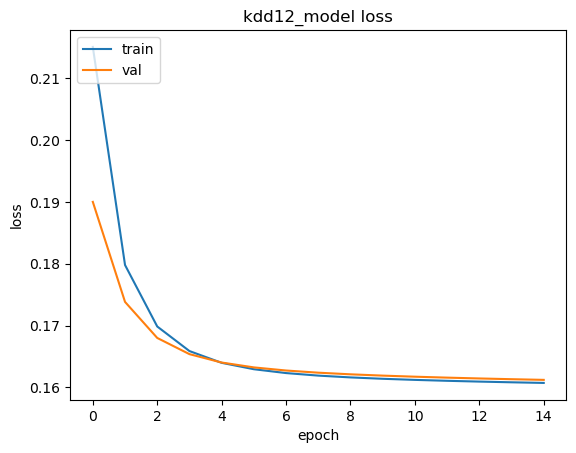

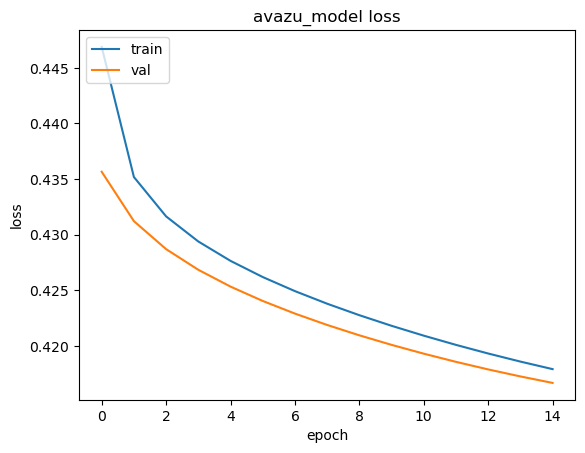

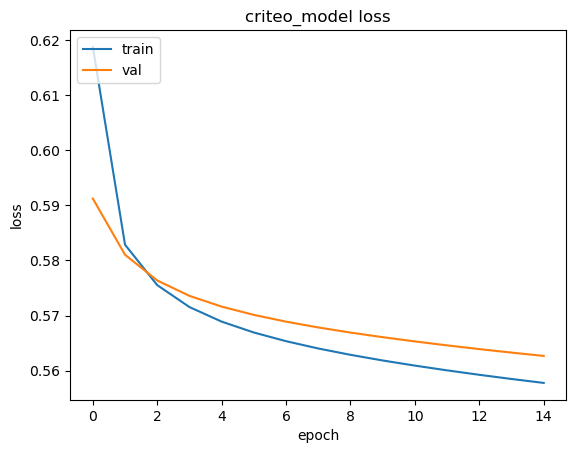

In [ ]:
# Plot the training and validation losses for each epoch
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_fm.csv')
avazu_history = pd.read_csv('logs/avazu_fm.csv')
criteo_history = pd.read_csv('logs/criteo_fm.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Deep Models

As explained above, I will explore a number of deep learning models. I selected five popular models on the basis of the following criteria

- Competitive predition accuracy in the KDD12, Criteo and Avazu datasets as published on [PapersWithCode](https://paperswithcode.com/)
- Ideally, I was looking for a representitive set of models for each model type as discussed in (Zhang et. al. 2021). Therefore I was looking for models that employed Product Interaction Opetators, Attention Operators and Factorization Machines as a basis.
- The code for the model has to be accessible and intuitive to use.

On the basis of the above critea, I have chosen the following models to explore:

- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Automatic Feature Interaction (AutoInt)

In the section below, I briefly introduce each of the models, and evaluate against the benchmark datasets loaded and preprocessed above.

### Factorization-Machine Supported Neural Networks

The first Deep Learning model that we will consider is the Factorization Supported
Neural Network (FNN) model proposed by Zhang et. al. (2016). The model works by first training a Factorization Machine
model on the sparse-encoded categorical input features. It then uses the latent vectors learned by the FM model (see $\mathbf{v}_i$ in the equation above)
as inputs to a Neural Network, as shown in the figure below. In doing so, the FNN model is effectively using the FM latent factors to initialize the embedding layer of the Neural Network.
The DNN is then able to learn the higher order feature interactions in the data, which the FM model is unable to capture.

![FNN](figures/fnn.png)

In [ ]:
# Compile the models
kdd12_fnn_model = FNN(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
kdd12_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_fnn_model = FNN(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
avazu_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_fnn_model = FNN(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
criteo_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [ ]:
# Define the CSVLogger callbacks
kdd12_fnn_csvLogger = CSVLogger('logs/kdd12_fnn.csv')
avazu_fnn_csvLogger = CSVLogger('logs/avazu_fnn.csv')
criteo_fnn_csvLogger = CSVLogger('logs/criteo_fnn.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/kdd12/kdd12_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/avazu/avazu_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/criteo/criteo_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the models
kdd12_fnn_history = kdd12_fnn_model.fit(kdd12_train_model_input, validation_data=kdd12_val_model_input, batch_size=256, epochs=15, callbacks=[kdd12_fnn_csvLogger,kdd12_fnn_modelCheckpoint,earlystopping])
#avazu_fnn_history = avazu_fnn_model.fit(avazu_train_model_input, validation_data=avazu_val_model_input, batch_size=256, epochs=15, callbacks=[avazu_fnn_csvLogger,avazu_fnn_modelCheckpoint,earlystopping])
#criteo_fnn_history = criteo_fnn_model.fit(criteo_train_model_input, validation_data=criteo_val_model_input, batch_size=256, epochs=15, callbacks=[criteo_fnn_csvLogger,criteo_fnn_modelCheckpoint,earlystopping])

Epoch 1/15


2024-08-07 19:01:04.969741: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f8d546c250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-07 19:01:04.969787: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-08-07 19:01:04.974472: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-07 19:01:04.992005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-08-07 19:01:05.081070: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    614/Unknown - 24s 30ms/step - loss: 0.3844 - binary_crossentropy: 0.1766 - binary_accuracy: 0.9525 - precision: 0.0568 - recall: 0.0028 - auc: 0.5614

2024-08-07 19:01:31.284097: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5556752150203412335


615/615 [==============================] - 30s 41ms/step - loss: 0.3840 - binary_crossentropy: 0.1766 - binary_accuracy: 0.9526 - precision: 0.0568 - recall: 0.0028 - auc: 0.5612 - val_loss: 0.1729 - val_binary_crossentropy: 0.1642 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5851
Epoch 2/15
615/615 [==============================] - 24s 39ms/step - loss: 0.1712 - binary_crossentropy: 0.1663 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5543 - val_loss: 0.1661 - val_binary_crossentropy: 0.1626 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6168
Epoch 3/15
615/615 [==============================] - 24s 39ms/step - loss: 0.1674 - binary_crossentropy: 0.1640 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5774 - val_loss: 0.1650 - val_binary_crossentropy: 0.1616 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

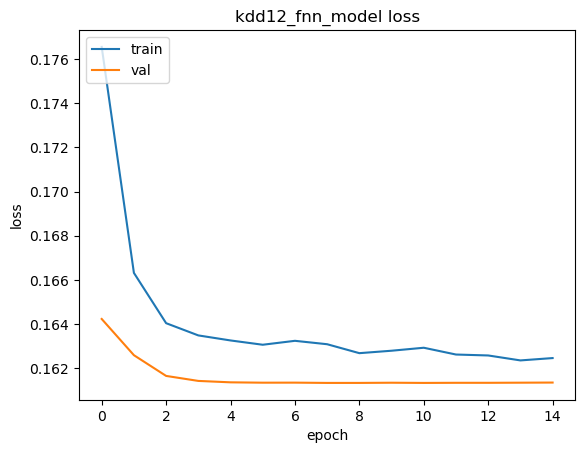

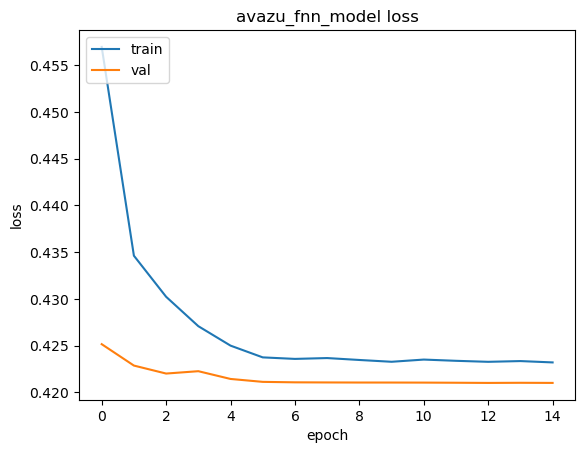

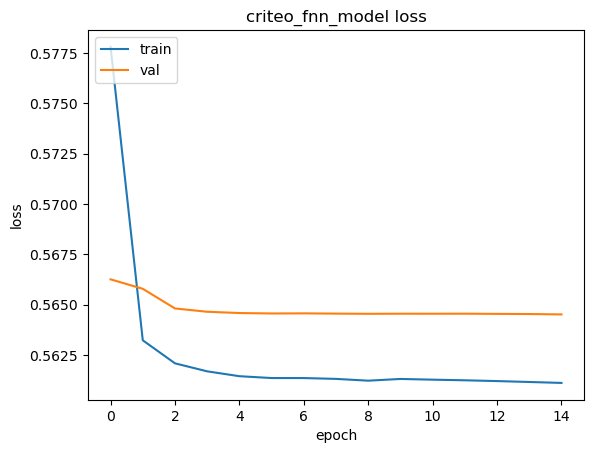

In [ ]:
# Read in the history logs
kdd12_fnn_history = pd.read_csv('logs/kdd12_fnn.csv')
avazu_fnn_history = pd.read_csv('logs/avazu_fnn.csv')
criteo_fnn_history = pd.read_csv('logs/criteo_fnn.csv')

# Plot the training history
plt.plot(kdd12_fnn_history['binary_crossentropy'])
plt.plot(kdd12_fnn_history['val_binary_crossentropy'])
plt.title('kdd12_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_fnn_history['binary_crossentropy'])
plt.plot(avazu_fnn_history['val_binary_crossentropy'])
plt.title('avazu_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_fnn_history['binary_crossentropy'])
plt.plot(criteo_fnn_history['val_binary_crossentropy'])
plt.title('criteo_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Product Based Neural Networks

The Product Based Neural Network (PNN) model
proposed by Qu et. al. (2016) is another Deep Learning
model that was developed around the same time as the FNN model. The key 
innovation of the PNN moel is the use of a pair-wisely connected Product Layer
after a field-wise connected embetting layer for the categorical features, as shown
in the figure below. The Product Layer is able to directly model inter-field feature
interaction by means of either an inner product or outer production operation, and then further
distill higher feature inturactions by passing the output of the Product Layer through fully
connected MLP layers.

![PNN](figures/pnn.png)

In [ ]:
# Define the CSVLogger callbacks
kdd12_pnn_csvLogger = CSVLogger('logs/kdd12_pnn.csv')
avazu_pnn_csvLogger = CSVLogger('logs/avazu_pnn.csv')
criteo_pnn_csvLogger = CSVLogger('logs/criteo_pnn.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/kdd12/kdd12_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/avazu/avazu_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/criteo/criteo_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Compile the PNN models
kdd12_pnn_model = PNN(
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
kdd12_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_pnn_model = PNN(
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
avazu_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_pnn_model = PNN(
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
criteo_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [ ]:
# Fit the models

kdd12_pnn_history = kdd12_pnn_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_pnn_csvLogger,kdd12_pnn_modelCheckpoint,earlystopping]
)
'''
avazu_pnn_history = avazu_pnn_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_pnn_csvLogger,avazu_pnn_modelCheckpoint,earlystopping]
)
criteo_pnn_history = criteo_pnn_model.fit(
    criteo_train_model_input,
    validation_data=criteo_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_pnn_csvLogger,criteo_pnn_modelCheckpoint,earlystopping]
)
'''

Epoch 1/15
    614/Unknown - 21s 30ms/step - loss: 0.3918 - binary_crossentropy: 0.1753 - binary_accuracy: 0.9537 - precision: 0.0446 - recall: 0.0011 - auc: 0.5563

2024-08-07 19:07:35.928772: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5059818466617257093
2024-08-07 19:07:40.913114: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 765993888292280483
2024-08-07 19:07:40.913164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4708687813049768452
2024-08-07 19:07:40.913175: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11552726153436139132


615/615 [==============================] - 27s 40ms/step - loss: 0.3913 - binary_crossentropy: 0.1752 - binary_accuracy: 0.9538 - precision: 0.0446 - recall: 0.0011 - auc: 0.5563 - val_loss: 0.1686 - val_binary_crossentropy: 0.1649 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5846
Epoch 2/15
615/615 [==============================] - 24s 39ms/step - loss: 0.1701 - binary_crossentropy: 0.1680 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5050 - val_loss: 0.1670 - val_binary_crossentropy: 0.1658 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/15
615/615 [==============================] - 24s 39ms/step - loss: 0.1689 - binary_crossentropy: 0.1679 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4996 - val_loss: 0.1666 - val_binary_crossentropy: 0.1658 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

'\navazu_pnn_history = avazu_pnn_model.fit(\n    avazu_train_model_input,\n    validation_data=avazu_val_model_input,\n    batch_size=256, \n    epochs=15,\n    callbacks=[avazu_pnn_csvLogger,avazu_pnn_modelCheckpoint,earlystopping]\n)\ncriteo_pnn_history = criteo_pnn_model.fit(\n    criteo_train_model_input,\n    validation_data=criteo_val_model_input,\n    batch_size=256, \n    epochs=15,\n    callbacks=[criteo_pnn_csvLogger,criteo_pnn_modelCheckpoint,earlystopping]\n)\n'

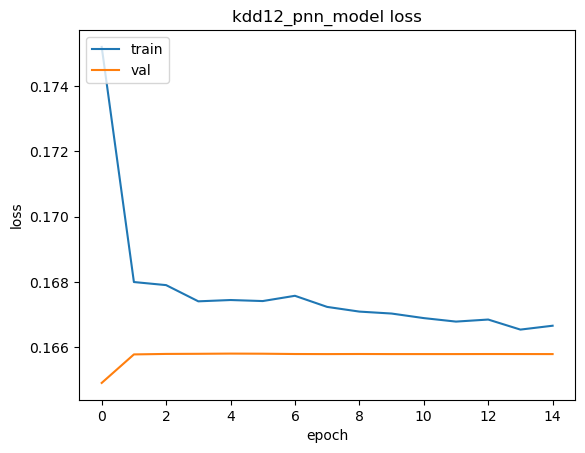

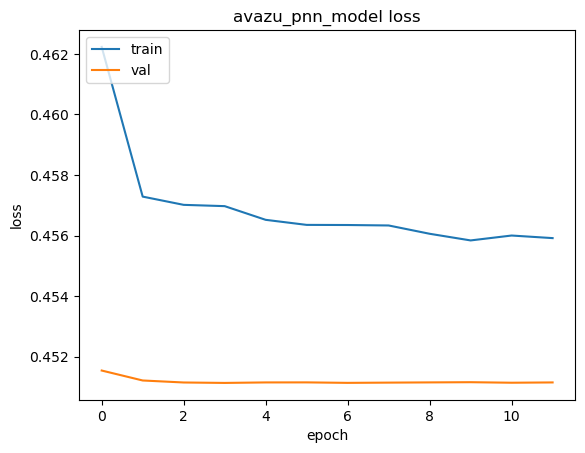

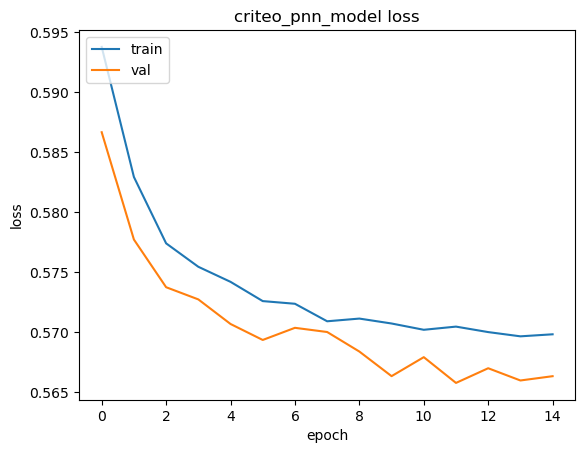

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_pnn.csv')
avazu_history = pd.read_csv('logs/avazu_pnn.csv')
criteo_history = pd.read_csv('logs/criteo_pnn.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Wide and Deep

The Wide \& Deep Learning (WDL) model proposed by Cheng et. al. (2016) introduces the concept
of dual-tower model architecture (Zhang et. al. 2021). While both the FNN and the PNN models
generally tend to be constructed as a single fully connected DNN model, the Wide \& Deep model
consists of a wide component, consisting of a three layer Deep Neural Network that takes the concatinated
embedding vectors of the categorical features as input, and a deep component, consisting of a cross product
transformation of selected sparse categorical features. The logits from the wide and deep components are added
together to produce the final prediction. The architecture of the WDL model is shown in the figure below.

![WDL](figures/wdl.png)

The purpose behind the Dual-Tower architecture is to counteract the tendancy of the fully connected
single tower DNN models to lose the ability to capture low-order feature interactions (Zhang et. al. 2021).
The Wide component is able to capture the low-order feature interactions, while the Deep component is able to capture
the higher order feature interactions.

In [ ]:
# Compile the WDL models
kdd12_wdl_model = WDL(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
kdd12_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_wdl_model = WDL(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
avazu_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_wdl_model = WDL(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
criteo_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [ ]:
# Define the CSVLogger callbacks
kdd12_wdl_csvLogger = CSVLogger('logs/kdd12_wdl.csv')
avazu_wdl_csvLogger = CSVLogger('logs/avazu_wdl.csv')
criteo_wdl_csvLogger = CSVLogger('logs/criteo_wdl.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/kdd12/kdd12_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/avazu/avazu_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/criteo/criteo_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the Wide and Deep models

kdd12_wdl_history = kdd12_wdl_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[kdd12_wdl_csvLogger,kdd12_wdl_modelCheckpoint,earlystopping]
)
'''
avazu_wdl_history = avazu_wdl_model.fit(
    avazu_train_model_input, 
    validation_data=avazu_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_wdl_csvLogger,avazu_wdl_modelCheckpoint,earlystopping]


criteo_wdl_history = criteo_wdl_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_wdl_csvLogger, criteo_wdl_modelCheckpoint,earlystopping]
)
'''

Epoch 1/15
    614/Unknown - 22s 31ms/step - loss: 0.3790 - binary_crossentropy: 0.1744 - binary_accuracy: 0.9535 - precision: 0.0383 - recall: 0.0011 - auc: 0.5462

2024-08-07 19:13:41.822440: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16926893388895715607
2024-08-07 19:13:46.873801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7346324704292119177
2024-08-07 19:13:46.873852: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13024232663869477531
2024-08-07 19:13:46.873872: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2017479901032410106
2024-08-07 19:13:46.873904: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7914288149543668706
2024-08-07 19:13:46.873916: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4649873882436492306


615/615 [==============================] - 28s 40ms/step - loss: 0.3786 - binary_crossentropy: 0.1744 - binary_accuracy: 0.9536 - precision: 0.0383 - recall: 0.0011 - auc: 0.5461 - val_loss: 0.1674 - val_binary_crossentropy: 0.1624 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6432
Epoch 2/15
615/615 [==============================] - 24s 39ms/step - loss: 0.1684 - binary_crossentropy: 0.1645 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5713 - val_loss: 0.1654 - val_binary_crossentropy: 0.1616 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6433
Epoch 3/15
615/615 [==============================] - 24s 39ms/step - loss: 0.1676 - binary_crossentropy: 0.1639 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5794 - val_loss: 0.1649 - val_binary_crossentropy: 0.1614 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

'\navazu_wdl_history = avazu_wdl_model.fit(\n    avazu_train_model_input, \n    validation_data=avazu_val_model_input, \n    batch_size=256, \n    epochs=15,\n    callbacks=[avazu_wdl_csvLogger,avazu_wdl_modelCheckpoint,earlystopping]\n\n\ncriteo_wdl_history = criteo_wdl_model.fit(\n    criteo_train_model_input, \n    validation_data=criteo_val_model_input, \n    batch_size=256, \n    epochs=15,\n    callbacks=[criteo_wdl_csvLogger, criteo_wdl_modelCheckpoint,earlystopping]\n)\n'

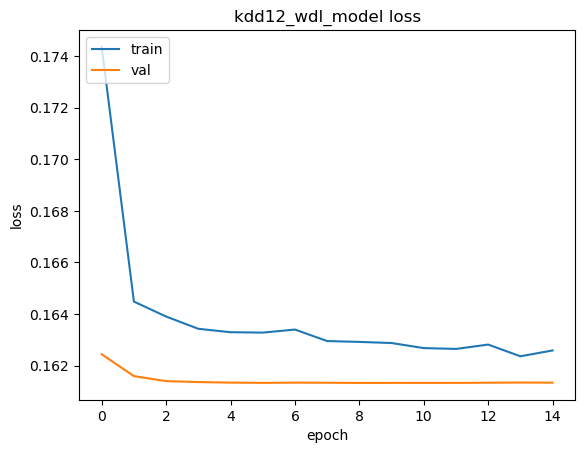

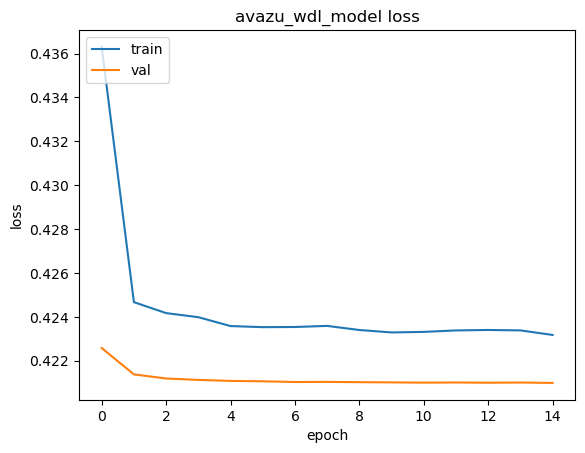

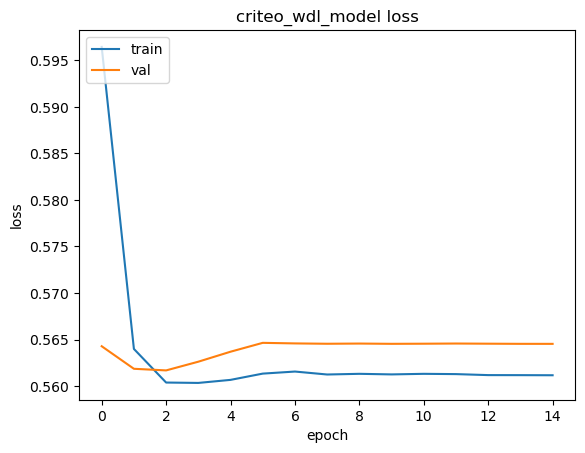

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_wdl.csv')
avazu_history = pd.read_csv('logs/avazu_wdl.csv')
criteo_history = pd.read_csv('logs/criteo_wdl.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### DeepFM

The DeepFM model proposed by Guo et. al. 2017 can be thought of as an
imporvement of the aforementioned FNN (Zhang et. al., 2016) and WDL (Cheng et. al., 2016) models.
Like the FNN model, the DeepFM model usilises the Factorization Machine model (Rendel, 2010)
to learn lower-order feature interactions. However, it also employs a dual-tower architecture
like the WDL model, with the Wide component being the FM model and the Deep component being a fully connected
DNN model. The DeepFM model is therefore able to avoid the limitations on capturing low-order
interactions that are inherent in the FNN model. In addition, due the the application of the FM to all
feature embeddings, the DeepFM model eliminates the need to choose which features 
to feed through the wide component, as is the case in the WDL model. The architecture of the DeepFM model is shown 
in the figure below.

![DFM](figures/dfm.png)

In [ ]:
# Compile the DeepFM models

kdd12_dfm_model = DeepFM(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
kdd12_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_dfm_model = DeepFM(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
avazu_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_dfm_model = DeepFM(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
criteo_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [ ]:
# Define the CSVLogger callbacks
kdd12_dfm_csvLogger = CSVLogger('logs/kdd12_dfm.csv')
avazu_dfm_csvLogger = CSVLogger('logs/avazu_dfm.csv')
criteo_dfm_csvLogger = CSVLogger('logs/criteo_dfm.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/kdd12/kdd12_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/avazu/avazu_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/criteo/criteo_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the DeepFM models

kdd12_dfm_history = kdd12_dfm_model.fit(
    kdd12_train_model_input, 
    validation_data = kdd12_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[kdd12_dfm_csvLogger,kdd12_dfm_modelCheckpoint,earlystopping]
)
'''
avazu_dfm_history = avazu_dfm_model.fit(
    avazu_train_model_input, 
    validation_data= avazu_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_dfm_csvLogger,avazu_dfm_modelCheckpoint,earlystopping]
)

criteo_dfm_history = criteo_dfm_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, epochs=15,
    callbacks=[criteo_dfm_csvLogger,criteo_dfm_modelCheckpoint,earlystopping]
)
'''

Epoch 1/15
615/615 [==============================] - 29s 40ms/step - loss: 0.6638 - binary_crossentropy: 0.2080 - binary_accuracy: 0.9417 - precision: 0.0405 - recall: 0.0104 - auc: 0.5533 - val_loss: 0.2211 - val_binary_crossentropy: 0.1650 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5599
Epoch 2/15
615/615 [==============================] - 24s 39ms/step - loss: 0.2116 - binary_crossentropy: 0.1741 - binary_accuracy: 0.9548 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5678 - val_loss: 0.1946 - val_binary_crossentropy: 0.1649 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6270
Epoch 3/15
615/615 [==============================] - 24s 39ms/step - loss: 0.1958 - binary_crossentropy: 0.1699 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5680 - val_loss: 0.1884 - val_binary_crossentropy: 0.1633 - val_binary_accuracy: 0.9553 - val_precision: 0.0000

'\navazu_dfm_history = avazu_dfm_model.fit(\n    avazu_train_model_input, \n    validation_data= avazu_val_model_input, \n    batch_size=256, \n    epochs=15,\n    callbacks=[avazu_dfm_csvLogger,avazu_dfm_modelCheckpoint,earlystopping]\n)\n\ncriteo_dfm_history = criteo_dfm_model.fit(\n    criteo_train_model_input, \n    validation_data=criteo_val_model_input, \n    batch_size=256, epochs=15,\n    callbacks=[criteo_dfm_csvLogger,criteo_dfm_modelCheckpoint,earlystopping]\n)\n'

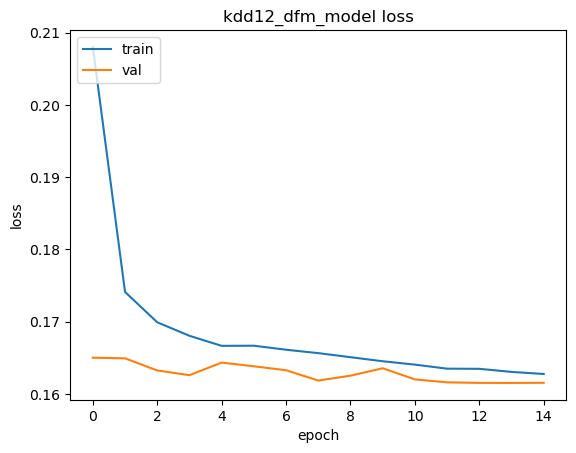

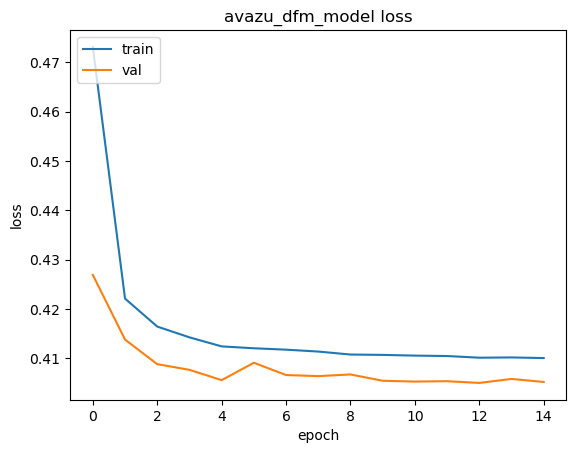

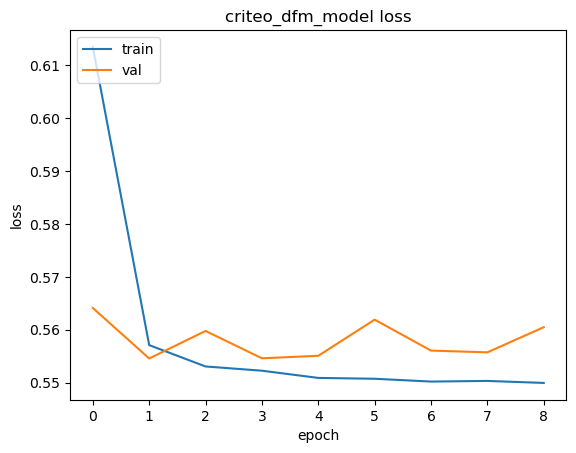

In [ ]:
# Read in the history logs
kdd12_dfm_history = pd.read_csv('logs/kdd12_dfm.csv')
avazu_dfm_history = pd.read_csv('logs/avazu_dfm.csv')
criteo_dfm_history = pd.read_csv('logs/criteo_dfm.csv')

# Plot the training history
plt.plot(kdd12_dfm_history['binary_crossentropy'])
plt.plot(kdd12_dfm_history['val_binary_crossentropy'])
plt.title('kdd12_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_dfm_history['binary_crossentropy'])
plt.plot(avazu_dfm_history['val_binary_crossentropy'])
plt.title('avazu_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_dfm_history['binary_crossentropy'])
plt.plot(criteo_dfm_history['val_binary_crossentropy'])
plt.title('criteo_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Automatic Feature Interaction (AutoInt)

The Autotomatic Feature Interaction Learning (AutoInt) model proposed by
Song et. al. (2019) makes use of a multi-head self attention
network to model the important feature interactions in the data. The initial 
paper separates the model into three parts: an embedding layer, an interaction layer 
and an output layer. The embedding layer aims to project each sparse multi-value
categorical a and dense numerical feature into a lower dimensional space, as per the below:

$$
\mathbf{e_i} = \frac{1}{q} \mathbf{V_i x_i}
$$

where $\mathbf{V_i}$ is the embedding matrix for the $i$-th field, $x_i$ is a multi-hot vector, and $q$ 
is the number of non-zero values in $x_i$. The interaction layer employs the multi-head
mechanism to determine which higher order feature interaction are meaningful in the data. This not only
improves the efficiency of model traning, but it also improves the model's explainability. Lastly,
the output layer is a fully connected layer that takes in the concatinated output 
of the interaction layer, and applies the sigmoid activation function to produce the final prediction.
The architecture of the AutoInt model is shown in Figure below.

![AUTOINT](figures/autoint.png)

In [ ]:
# Compile the AutoInt Models
kdd12_autoint_model = AutoInt(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
kdd12_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_autoint_model = AutoInt(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
avazu_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_autoint_model = AutoInt(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
criteo_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [ ]:
# Define the AutoInt CSVLogger callbacks
kdd12_autoint_csvLogger = CSVLogger('logs/kdd12_autoint.csv')
avazu_autoint_csvLogger = CSVLogger('logs/avazu_autoint.csv')
criteo_autoint_csvLogger = CSVLogger('logs/criteo_autoint.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/kdd12/kdd12_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/avazu/avazu_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/criteo/criteo_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the AutoInt models

kdd12_autoint_model.fit(
    kdd12_train_model_input, 
    validation_data= kdd12_val_model_input, 
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_autoint_csvLogger, kdd12_autoint_modelCheckpoint,earlystopping]
)
'''
avazu_autoint_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[avazu_autoint_csvLogger, avazu_autoint_modelCheckpoint,earlystopping]
)
criteo_autoint_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_autoint_csvLogger,criteo_autoint_modelCheckpoint,earlystopping]
)
'''

Epoch 1/15
615/615 [==============================] - 31s 41ms/step - loss: 0.5905 - binary_crossentropy: 0.1895 - binary_accuracy: 0.9473 - precision: 0.0465 - recall: 0.0070 - auc: 0.5922 - val_loss: 0.2326 - val_binary_crossentropy: 0.1625 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6290
Epoch 2/15
615/615 [==============================] - 24s 40ms/step - loss: 0.2290 - binary_crossentropy: 0.1660 - binary_accuracy: 0.9550 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6253 - val_loss: 0.2316 - val_binary_crossentropy: 0.1631 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6354
Epoch 3/15
615/615 [==============================] - 24s 38ms/step - loss: 0.2332 - binary_crossentropy: 0.1616 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6456 - val_loss: 0.2444 - val_binary_crossentropy: 0.1618 - val_binary_accuracy: 0.9553 - val_precision: 0.0000

'\navazu_autoint_model.fit(\n    avazu_train_model_input,\n    validation_data=avazu_val_model_input,\n    batch_size=256, \n    epochs=15, \n    callbacks=[avazu_autoint_csvLogger, avazu_autoint_modelCheckpoint,earlystopping]\n)\ncriteo_autoint_model.fit(\n    criteo_train_model_input, \n    validation_data=criteo_val_model_input, \n    batch_size=256, \n    epochs=15,\n    callbacks=[criteo_autoint_csvLogger,criteo_autoint_modelCheckpoint,earlystopping]\n)\n'

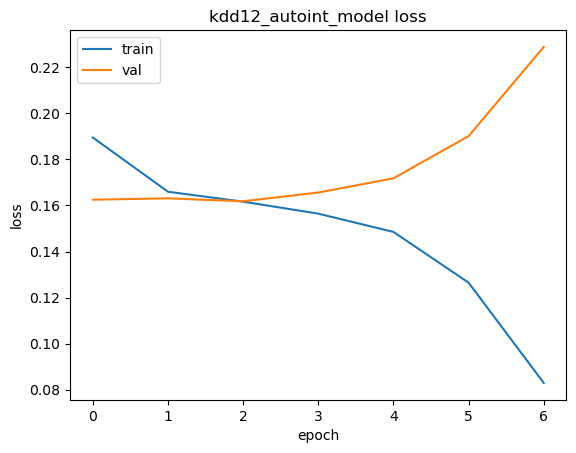

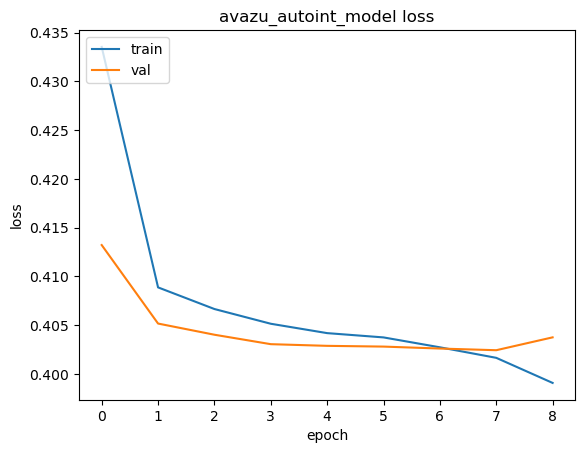

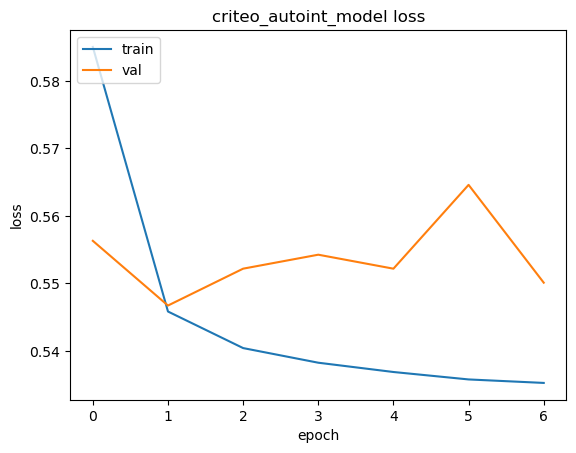

In [ ]:
# Read in the history logs
kdd12_autoint_history = pd.read_csv('logs/kdd12_autoint.csv')
avazu_autoint_history = pd.read_csv('logs/avazu_autoint.csv')
criteo_autoint_history = pd.read_csv('logs/criteo_autoint.csv')

# Plot the training history
plt.plot(kdd12_autoint_history['binary_crossentropy'])
plt.plot(kdd12_autoint_history['val_binary_crossentropy'])
plt.title('kdd12_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_autoint_history['binary_crossentropy'])
plt.plot(avazu_autoint_history['val_binary_crossentropy'])
plt.title('avazu_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_autoint_history['binary_crossentropy'])
plt.plot(criteo_autoint_history['val_binary_crossentropy'])
plt.title('criteo_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Feature Generation by Convolutional Neural Network

In [46]:
# Compile the AutoInt Models

kdd12_fgcnn_model = FGCNN(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    pooling_width=[2,2,2,1]
    )
kdd12_fgcnn_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
    run_eagerly=True,
)

avazu_fgcnn_model = FGCNN(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    pooling_width=[2,2,2,1]
    )
avazu_fgcnn_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
    run_eagerly=True,
)

criteo_fgcnn_model = FGCNN(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    pooling_width=[2,2,2,1]
    )
criteo_fgcnn_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
    run_eagerly=True,
)

In [47]:
# Define the AutoInt CSVLogger callbacks
kdd12_fgcnn_csvLogger = CSVLogger('logs/kdd12_fgcnn.csv')
avazu_fgcnn_csvLogger = CSVLogger('logs/avazu_fgcnn.csv')
criteo_fgcnn_csvLogger = CSVLogger('logs/criteo_fgcnn.csv')

In [48]:
# Define the model saving checkpoints
kdd12_fgcnn_modelCheckpoint = ModelCheckpoint(
    'models/fgcnn/kdd12/kdd12_fgcnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_fgcnn_modelCheckpoint = ModelCheckpoint(
    'models/fgcnn/avazu/avazu_fgcnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_fgcnn_modelCheckpoint = ModelCheckpoint(
    'models/fgcnn/criteo/criteo_fgcnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the FGCNN models

kdd12_fgcnn_model.fit(
    kdd12_train_model_input, 
    validation_data= kdd12_val_model_input, 
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_fgcnn_csvLogger, kdd12_fgcnn_modelCheckpoint,earlystopping]
)

avazu_fgcnn_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[avazu_fgcnn_csvLogger, avazu_fgcnn_modelCheckpoint,earlystopping]
)
criteo_fgcnn_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_fgcnn_csvLogger,criteo_fgcnn_modelCheckpoint,earlystopping]
)

Epoch 1/15


2024-08-14 13:29:59.938588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-08-14 13:30:00.328273: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-14 13:30:00.329165: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-14 13:30:00.329205: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-08-14 13:30:00.329906: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-14 13:30:00.330008: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

615/615 [==============================] - 112s 164ms/step - loss: 0.4108 - binary_crossentropy: 0.1812 - binary_accuracy: 0.9511 - precision: 0.0506 - recall: 0.0050 - auc: 0.5491 - val_loss: 0.1754 - val_binary_crossentropy: 0.1603 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6565
Epoch 2/15
615/615 [==============================] - 99s 161ms/step - loss: 0.1762 - binary_crossentropy: 0.1633 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5959 - val_loss: 0.1765 - val_binary_crossentropy: 0.1606 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6567
Epoch 3/15
597/615 [============================>.] - ETA: 2s - loss: 0.1787 - binary_crossentropy: 0.1628 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6005

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_fgcnn.csv')
avazu_history = pd.read_csv('logs/avazu_fgcnn.csv')
criteo_history = pd.read_csv('logs/criteo_fgcnn.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_fgcnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_fgcnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_fgcnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Analysis of Results and Discussion

Below I construct and display a pandas dataframe of the best results in each of the logs in terms of validation loss. The accompanying validation metrics are also shown

In [87]:
# Construct pandas dataframe of the model scores for the kdd12 dataset
models = ['lr','fm','fnn','pnn','wdl','dfm','autoint']
datasets = ['kdd12','avazu','criteo']

for dataset in datasets:
    df = pd.DataFrame()
    for model in models:
        log_file = f'logs/{dataset}_{model}.csv'
        history = pd.read_csv(log_file)
        min_loss = history[history['val_loss']==history['val_loss'].min()]
        min_loss_val = min_loss.loc[:,['epoch','val_binary_crossentropy','val_binary_accuracy','val_precision','val_recall','val_auc']]
        min_loss_val['model'] = model
        df = pd.concat([df,min_loss_val],axis=0)
    df = df.set_index('model')
    df.to_csv(f'logs/{dataset}_model_scores.csv')

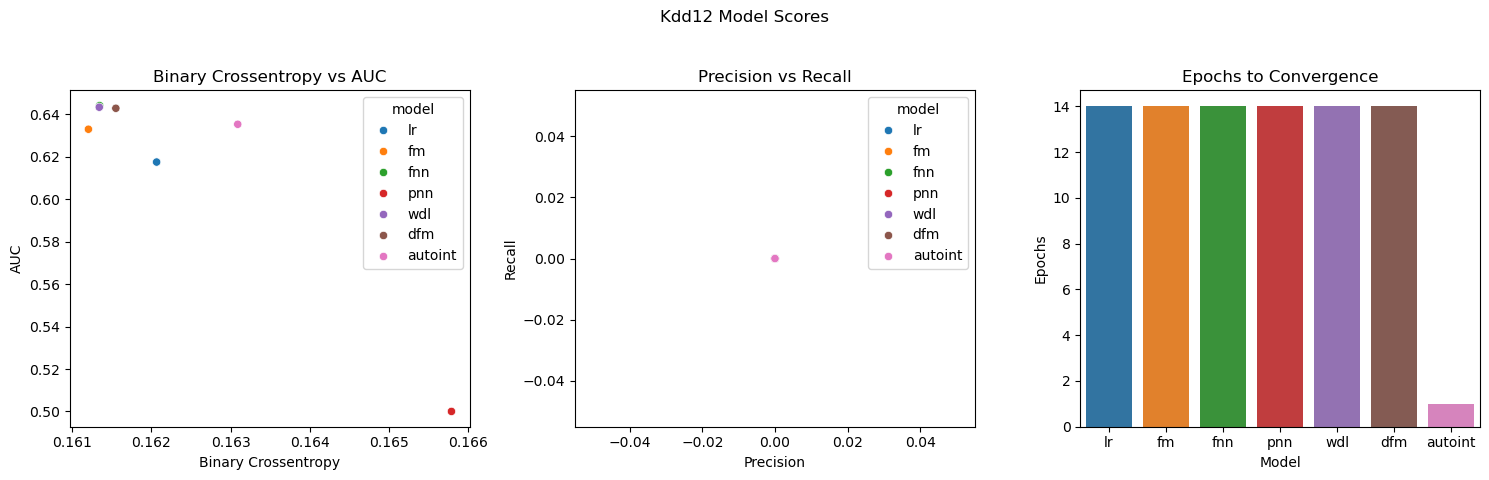

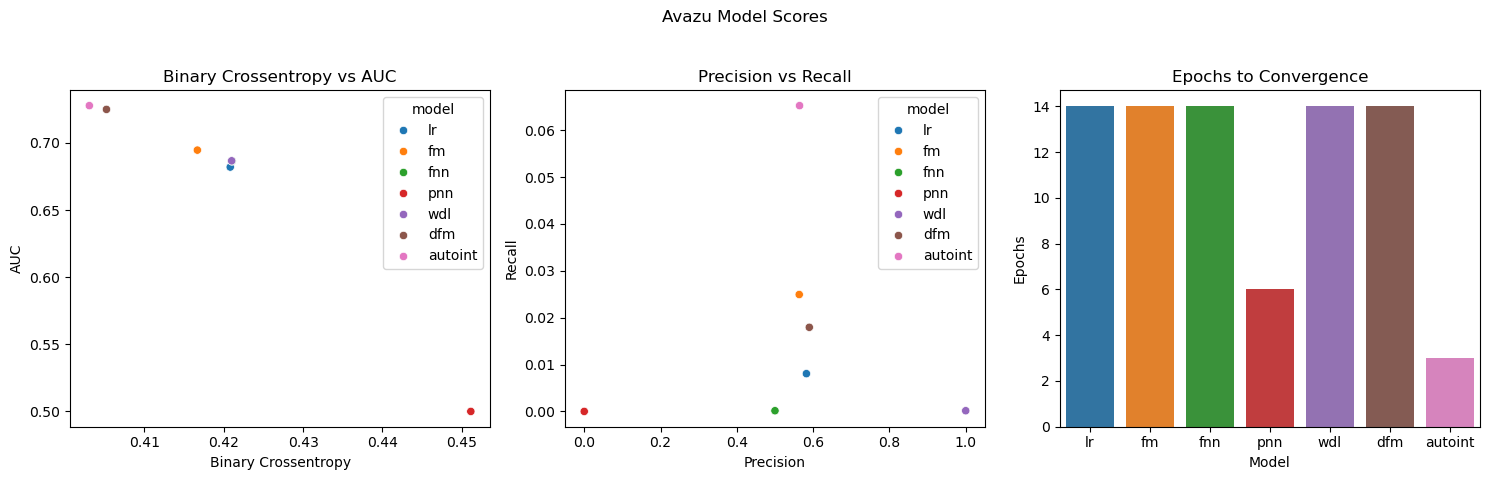

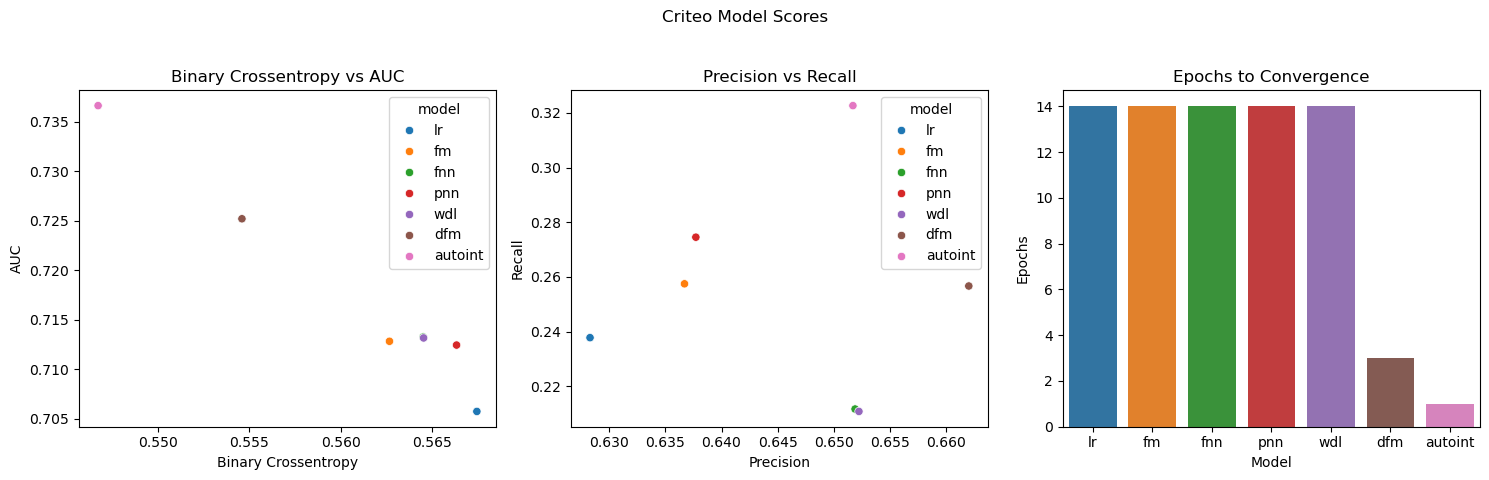

In [89]:
# Plot the the model scores by data set

for dataset in datasets:
    df = pd.read_csv(f'logs/{dataset}_model_scores.csv')
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{dataset.capitalize()} Model Scores')
    
    # Plot a scatter plot of binary crossentropy loss vs binary accuracy
    sns.scatterplot(ax=axs[0], data=df, x='val_binary_crossentropy', y='val_auc', hue='model', palette='tab10')
    axs[0].set_title('Binary Crossentropy vs AUC')
    axs[0].set_xlabel('Binary Crossentropy')
    axs[0].set_ylabel('AUC')

    # Plot a scatter plot of Precision vs Recall
    sns.scatterplot(ax=axs[1], data=df, x='val_precision', y='val_recall', hue='model', palette='tab10')
    axs[1].set_title('Precision vs Recall')
    axs[1].set_xlabel('Precision')
    axs[1].set_ylabel('Recall')

    # Plot a bar chart of epoch number by model
    sns.barplot(ax=axs[2], data=df, x='model', y='epoch', palette='tab10')
    axs[2].set_title('Epochs to Convergence')
    axs[2].set_xlabel('Model')
    axs[2].set_ylabel('Epochs')

    # Arrange the subplots so that the axis labels do not overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the figure in the figures folder and show the plot
    plt.savefig(f'figures/{dataset}_model_scores.png')
    plt.show()

## Hyperparameter Experimentation

In this section, I experiment with different hyperparameter settings for the DeepFM model, using the Avazu Dataset. Below I will experiment with:
- Neuron per layer count: 100, 200, 300, 400, 500
- Layer count: 2, 3, 4, 5, 6
- Architecture shape:
    - Flat: 200, 200, 200
    - Increasing: 100, 200, 300
    - Decreasing: 300, 200, 100
    - Diamond: 150, 300, 150

In [43]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters'):
    os.mkdir('models/hyperparameters')

### Neuron per Layer

In [44]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters/neuron_count'):
    os.mkdir('models/hyperparameters/neuron_count')

In [45]:
def neuron_experiment(dnn_hidden_layers):
    precision = tf.keras.metrics.Precision(thresholds=0.5,name='precision')
    recall = tf.keras.metrics.Recall(thresholds=0.5,name='recall')
    auc = tf.keras.metrics.AUC(name='auc')
    
    model = DeepFM(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=dnn_hidden_layers,
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
    model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

    return model

In [46]:
for neurons in [100,200,300,400,500]:
    if not os.path.exists(f'models/hyperparameters/neuron_count/{str(neurons)}'):
        os.mkdir(f'models/hyperparameters/neuron_count/{str(neurons)}')

    dnn_layers = 3*[neurons]
    model = neuron_experiment(dnn_layers)

    csvLogger = CSVLogger(f'logs/neuron_count_{str(neurons)}.csv')
    modelCheckpoint = ModelCheckpoint(
    f'models/hyperparameters/neuron_count/{str(neurons)}/neuron_count_{str(neurons)}.ckpt',
    save_best_only=True,
    save_weights_only=True
    )

    print(f"{str(neurons)} neurons:")
    model.fit(
        kdd12_train_model_input,
        validation_data = kdd12_val_model_input,
        batch_size=256,
        epochs=15,
        callbacks=[csvLogger,modelCheckpoint,earlystopping]
    )

100 neurons:
Epoch 1/15


2024-08-09 09:20:08.815235: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-09 09:20:11.556948: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8f4c97bea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-09 09:20:11.556989: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-08-09 09:20:11.583579: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-09 09:20:11.654559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-08-09 09:20:11.779111: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    614/Unknown - 28s 31ms/step - loss: 0.5197 - binary_crossentropy: 0.2036 - binary_accuracy: 0.9470 - precision: 0.0445 - recall: 0.0086 - auc: 0.5409

2024-08-09 09:20:38.590057: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1808081832411473093
2024-08-09 09:20:38.590109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5780704903761502744
2024-08-09 09:20:38.590120: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10355885632131306368
2024-08-09 09:20:38.590130: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2613238967880854878


615/615 [==============================] - 34s 41ms/step - loss: 0.5192 - binary_crossentropy: 0.2035 - binary_accuracy: 0.9471 - precision: 0.0445 - recall: 0.0086 - auc: 0.5408 - val_loss: 0.2178 - val_binary_crossentropy: 0.1662 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5770
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2033 - binary_crossentropy: 0.1743 - binary_accuracy: 0.9550 - precision: 0.0714 - recall: 1.4148e-04 - auc: 0.5602 - val_loss: 0.1813 - val_binary_crossentropy: 0.1616 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6346
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.1877 - binary_crossentropy: 0.1710 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5639 - val_loss: 0.1769 - val_binary_crossentropy: 0.1612 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_reca

2024-08-09 09:26:51.484970: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10431842628908500505
2024-08-09 09:26:51.485032: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11010403487689146275
2024-08-09 09:26:56.699732: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17821050193653999180


615/615 [==============================] - 30s 41ms/step - loss: 0.6589 - binary_crossentropy: 0.2068 - binary_accuracy: 0.9432 - precision: 0.0517 - recall: 0.0151 - auc: 0.5417 - val_loss: 0.2271 - val_binary_crossentropy: 0.1639 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6159
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2160 - binary_crossentropy: 0.1739 - binary_accuracy: 0.9549 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5617 - val_loss: 0.1963 - val_binary_crossentropy: 0.1634 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6165
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.1966 - binary_crossentropy: 0.1691 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5700 - val_loss: 0.1875 - val_binary_crossentropy: 0.1627 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

2024-08-09 09:33:24.270427: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12298274399571832991
2024-08-09 09:33:24.270502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4861203591904435757
2024-08-09 09:33:24.270525: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17271274547678237733
2024-08-09 09:33:24.270539: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10431842628908500505
2024-08-09 09:33:24.270552: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6020320326642712005
2024-08-09 09:33:24.270563: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3978613933827268285
2024-08-09 09:33:24.270576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

615/615 [==============================] - 30s 41ms/step - loss: 0.7468 - binary_crossentropy: 0.2029 - binary_accuracy: 0.9435 - precision: 0.0483 - recall: 0.0137 - auc: 0.5506 - val_loss: 0.2238 - val_binary_crossentropy: 0.1673 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5726
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2135 - binary_crossentropy: 0.1728 - binary_accuracy: 0.9549 - precision: 0.0645 - recall: 2.8297e-04 - auc: 0.5669 - val_loss: 0.1983 - val_binary_crossentropy: 0.1642 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6256
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2009 - binary_crossentropy: 0.1692 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5706 - val_loss: 0.1931 - val_binary_crossentropy: 0.1626 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_reca

2024-08-09 09:39:36.152386: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6748696678289377780
2024-08-09 09:39:36.152448: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7639770218240200308
2024-08-09 09:39:41.343734: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2613238967880854878
2024-08-09 09:39:41.343801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13669118867679234377
2024-08-09 09:39:41.343826: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1808081832411473093


615/615 [==============================] - 29s 40ms/step - loss: 0.7060 - binary_crossentropy: 0.1844 - binary_accuracy: 0.9534 - precision: 0.0340 - recall: 0.0014 - auc: 0.5566 - val_loss: 0.2286 - val_binary_crossentropy: 0.1675 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5381
Epoch 2/15
615/615 [==============================] - 24s 40ms/step - loss: 0.2160 - binary_crossentropy: 0.1691 - binary_accuracy: 0.9550 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5763 - val_loss: 0.2104 - val_binary_crossentropy: 0.1639 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6096
Epoch 3/15
615/615 [==============================] - 24s 40ms/step - loss: 0.2074 - binary_crossentropy: 0.1672 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5791 - val_loss: 0.2002 - val_binary_crossentropy: 0.1638 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

2024-08-09 09:45:48.182439: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12298274399571832991


615/615 [==============================] - 30s 41ms/step - loss: 0.8459 - binary_crossentropy: 0.1933 - binary_accuracy: 0.9499 - precision: 0.0483 - recall: 0.0061 - auc: 0.5563 - val_loss: 0.2468 - val_binary_crossentropy: 0.1660 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5971
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2364 - binary_crossentropy: 0.1717 - binary_accuracy: 0.9550 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5740 - val_loss: 0.2252 - val_binary_crossentropy: 0.1633 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6248
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2137 - binary_crossentropy: 0.1681 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5715 - val_loss: 0.2046 - val_binary_crossentropy: 0.1616 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

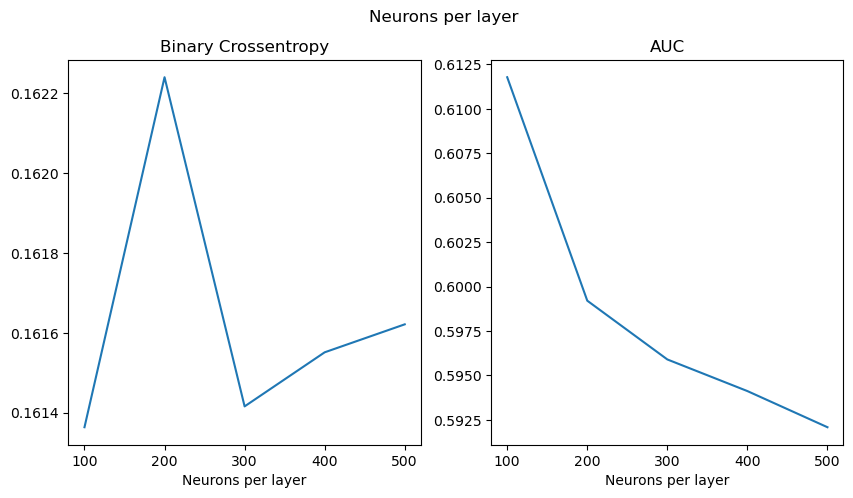

In [47]:
# Plot the minimum validation loss
summary_df = pd.DataFrame(index=np.arange(100,600,100),data={
    "binary_crossentropy":np.zeros(5,dtype=float),
    "auc":np.zeros(5,dtype=float)
})

for neurons in [100,200,300,400,500]:
    df = pd.read_csv(f'logs/neuron_count_{str(neurons)}.csv')
    binary_crossentropy = df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]
    auc = df[df.val_loss == df.val_loss.min()].auc.values[0]
    summary_df.loc[neurons,['binary_crossentropy']] = binary_crossentropy
    summary_df.loc[neurons,['auc']] = auc

# Plot the result
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.suptitle("Neurons per layer")
ax[0].set_title('Binary Crossentropy')
ax[0].set_xlabel('Neurons per layer')
ax[0].plot(summary_df.index,summary_df.binary_crossentropy)

ax[1].set_title('AUC')
ax[1].set_xlabel('Neurons per layer')
ax[1].plot(summary_df.index,summary_df.auc)

plt.show()

In [48]:
df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]

0.1616211980581283

### Number of layers

In [49]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters/layers'):
    os.mkdir('models/hyperparameters/layers')

In [50]:
for layers in [2,3,4,5,6]:
    if not os.path.exists(f'models/hyperparameters/layers/{str(layers)}'):
        os.mkdir(f'models/hyperparameters/layers/{str(layers)}')

    dnn_layers = layers*[200]
    model = neuron_experiment(dnn_layers)

    csvLogger = CSVLogger(f'logs/layers_{layers}.csv')
    modelCheckpoint = ModelCheckpoint(
    f'models/hyperparameters/layers/{str(layers)}/layers_{str(layers)}.ckpt',
    save_best_only=True,
    save_weights_only=True
    )

    print(f"{str(layers)} layers:")
    model.fit(
        kdd12_train_model_input,
        validation_data = kdd12_val_model_input,
        batch_size=256,
        epochs=15,
        callbacks=[csvLogger,modelCheckpoint,earlystopping]
    )

2 layers:
Epoch 1/15
    614/Unknown - 23s 31ms/step - loss: 0.4305 - binary_crossentropy: 0.2037 - binary_accuracy: 0.9438 - precision: 0.0473 - recall: 0.0130 - auc: 0.5432

2024-08-09 09:51:59.438258: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11474784309358620829
2024-08-09 09:51:59.438327: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11921167854093222373
2024-08-09 09:51:59.438341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16229712808683725673
2024-08-09 09:51:59.438351: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17271274547678237733
2024-08-09 09:51:59.438362: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10431842628908500505
2024-08-09 09:51:59.438372: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5803488624181660065
2024-08-09 09:51:59.438384: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous rec

615/615 [==============================] - 29s 41ms/step - loss: 0.4301 - binary_crossentropy: 0.2036 - binary_accuracy: 0.9438 - precision: 0.0473 - recall: 0.0130 - auc: 0.5431 - val_loss: 0.1944 - val_binary_crossentropy: 0.1647 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6272
Epoch 2/15
615/615 [==============================] - 24s 40ms/step - loss: 0.1925 - binary_crossentropy: 0.1725 - binary_accuracy: 0.9551 - precision: 0.1000 - recall: 1.4148e-04 - auc: 0.5655 - val_loss: 0.1801 - val_binary_crossentropy: 0.1639 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6373
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.1828 - binary_crossentropy: 0.1685 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5718 - val_loss: 0.1776 - val_binary_crossentropy: 0.1628 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_reca

2024-08-09 09:58:14.502952: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13669118867679234377
2024-08-09 09:58:14.503007: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10355885632131306368


615/615 [==============================] - 29s 41ms/step - loss: 0.5897 - binary_crossentropy: 0.1911 - binary_accuracy: 0.9504 - precision: 0.0375 - recall: 0.0042 - auc: 0.5509 - val_loss: 0.2112 - val_binary_crossentropy: 0.1650 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5924
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2026 - binary_crossentropy: 0.1713 - binary_accuracy: 0.9550 - precision: 0.0556 - recall: 1.4148e-04 - auc: 0.5703 - val_loss: 0.1907 - val_binary_crossentropy: 0.1643 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6133
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.1927 - binary_crossentropy: 0.1683 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5724 - val_loss: 0.1842 - val_binary_crossentropy: 0.1616 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_reca

2024-08-09 10:04:28.859387: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16229712808683725673
2024-08-09 10:04:28.859445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15004739223880226978
2024-08-09 10:04:28.859457: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4347848618564843242


615/615 [==============================] - 30s 41ms/step - loss: 0.8768 - binary_crossentropy: 0.2112 - binary_accuracy: 0.9399 - precision: 0.0453 - recall: 0.0167 - auc: 0.5406 - val_loss: 0.2305 - val_binary_crossentropy: 0.1675 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5753
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2196 - binary_crossentropy: 0.1739 - binary_accuracy: 0.9550 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5589 - val_loss: 0.2057 - val_binary_crossentropy: 0.1656 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5968
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2070 - binary_crossentropy: 0.1703 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5619 - val_loss: 0.1977 - val_binary_crossentropy: 0.1631 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

2024-08-09 10:10:39.081254: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12753115046863771771
2024-08-09 10:10:39.081325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5177096348136094435
2024-08-09 10:10:39.081338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16296982924044774587
2024-08-09 10:10:39.081348: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3275334274846879323
2024-08-09 10:10:39.081358: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14292772714711801831
2024-08-09 10:10:39.081370: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14332023486444394066
2024-08-09 10:10:39.081381: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

615/615 [==============================] - 31s 41ms/step - loss: 1.0961 - binary_crossentropy: 0.1976 - binary_accuracy: 0.9464 - precision: 0.0475 - recall: 0.0100 - auc: 0.5403 - val_loss: 0.2449 - val_binary_crossentropy: 0.1629 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6415
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2345 - binary_crossentropy: 0.1752 - binary_accuracy: 0.9549 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5533 - val_loss: 0.2191 - val_binary_crossentropy: 0.1651 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6429
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2193 - binary_crossentropy: 0.1700 - binary_accuracy: 0.9550 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5666 - val_loss: 0.2127 - val_binary_crossentropy: 0.1659 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

2024-08-09 10:16:53.894019: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6632073654530792018
2024-08-09 10:16:59.249361: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12753115046863771771
2024-08-09 10:16:59.249414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5177096348136094435
2024-08-09 10:16:59.249425: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14489413533324247861
2024-08-09 10:16:59.249435: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15020877196142798793
2024-08-09 10:16:59.249445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15243339910182491818


615/615 [==============================] - 31s 42ms/step - loss: 1.3771 - binary_crossentropy: 0.2061 - binary_accuracy: 0.9438 - precision: 0.0322 - recall: 0.0086 - auc: 0.5270 - val_loss: 0.2814 - val_binary_crossentropy: 0.1707 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5585
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2539 - binary_crossentropy: 0.1756 - binary_accuracy: 0.9549 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5491 - val_loss: 0.2458 - val_binary_crossentropy: 0.1692 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6472
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2328 - binary_crossentropy: 0.1707 - binary_accuracy: 0.9550 - precision: 0.1000 - recall: 2.8297e-04 - auc: 0.5600 - val_loss: 0.2252 - val_binary_crossentropy: 0.1678 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_reca

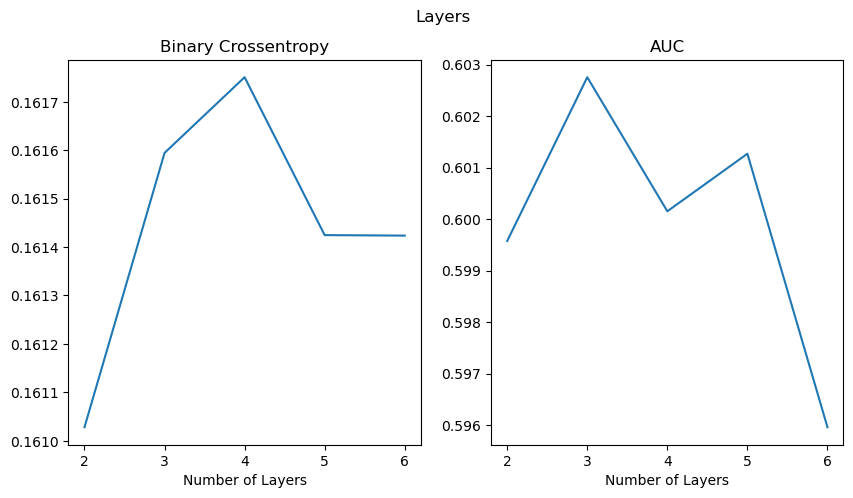

In [51]:
# Plot the minimum validation loss
summary_df = pd.DataFrame(index=np.arange(2,7),data={
    "binary_crossentropy":np.zeros(5,dtype=float),
    "auc":np.zeros(5,dtype=float)
})

for neurons in [2,3,4,5,6]:
    df = pd.read_csv(f'logs/layers_{str(neurons)}.csv')
    binary_crossentropy = df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]
    auc = df[df.val_loss == df.val_loss.min()].auc.values[0]
    summary_df.loc[neurons,['binary_crossentropy']] = binary_crossentropy
    summary_df.loc[neurons,['auc']] = auc


# Plot the result
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.suptitle("Layers")
ax[0].set_title('Binary Crossentropy')
ax[0].set_xlabel('Number of Layers')
ax[0].plot(summary_df.index,summary_df.binary_crossentropy)

ax[1].set_title('AUC')
ax[1].set_xlabel('Number of Layers')
ax[1].plot(summary_df.index,summary_df.auc)

plt.show()

### DNN Shape

In [52]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters/shape'):
    os.mkdir('models/hyperparameters/shape')

In [53]:
shapes = {
    'constant':[200,200,200],
    'increasing':[100,2000,300],
    'decreasing':[300,200,100],
    'diamond':[150,300,150]
}

In [54]:
for shape in list(shapes.keys()):
    if not os.path.exists(f'models/hyperparameters/shape/{shape}'):
        os.mkdir(f'models/hyperparameters/shape/{shape}')

    dnn_layers = shapes[shape]
    model = neuron_experiment(dnn_layers)

    csvLogger = CSVLogger(f'logs/shape_{shape}.csv')
    modelCheckpoint = ModelCheckpoint(
    f'models/hyperparameters/shape/{shape}/shape_{shape}.ckpt',
    save_best_only=True,
    save_weights_only=True
    )

    print(f"{shape.capitalize()}:")
    model.fit(
        kdd12_train_model_input,
        validation_data = kdd12_val_model_input,
        batch_size=256,
        epochs=15,
        callbacks=[csvLogger,modelCheckpoint,earlystopping]
    )

Constant:
Epoch 1/15
    614/Unknown - 23s 31ms/step - loss: 0.6223 - binary_crossentropy: 0.1979 - binary_accuracy: 0.9481 - precision: 0.0421 - recall: 0.0071 - auc: 0.5430

2024-08-09 10:23:10.508118: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7639770218240200308
2024-08-09 10:23:15.712942: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10355885632131306368


615/615 [==============================] - 29s 41ms/step - loss: 0.6216 - binary_crossentropy: 0.1979 - binary_accuracy: 0.9481 - precision: 0.0421 - recall: 0.0071 - auc: 0.5429 - val_loss: 0.2163 - val_binary_crossentropy: 0.1647 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5924
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2058 - binary_crossentropy: 0.1722 - binary_accuracy: 0.9550 - precision: 0.0417 - recall: 1.4148e-04 - auc: 0.5686 - val_loss: 0.1891 - val_binary_crossentropy: 0.1632 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6300
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.1930 - binary_crossentropy: 0.1687 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5751 - val_loss: 0.1885 - val_binary_crossentropy: 0.1650 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_reca

2024-08-09 10:29:30.278247: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13669118867679234377
2024-08-09 10:29:30.278307: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11921167854093222373


615/615 [==============================] - 29s 41ms/step - loss: 0.7257 - binary_crossentropy: 0.1994 - binary_accuracy: 0.9463 - precision: 0.0433 - recall: 0.0092 - auc: 0.5474 - val_loss: 0.2394 - val_binary_crossentropy: 0.1658 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5566
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2357 - binary_crossentropy: 0.1724 - binary_accuracy: 0.9550 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5732 - val_loss: 0.2229 - val_binary_crossentropy: 0.1667 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5628
Epoch 3/15
615/615 [==============================] - 24s 39ms/step - loss: 0.2219 - binary_crossentropy: 0.1683 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5729 - val_loss: 0.2279 - val_binary_crossentropy: 0.1680 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

2024-08-09 10:35:35.869536: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12298274399571832991
2024-08-09 10:35:35.869606: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11010403487689146275
2024-08-09 10:35:35.869618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17271274547678237733
2024-08-09 10:35:35.869627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10431842628908500505
2024-08-09 10:35:35.869637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6020320326642712005
2024-08-09 10:35:35.869647: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3978613933827268285
2024-08-09 10:35:35.869657: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

615/615 [==============================] - 30s 41ms/step - loss: 0.6763 - binary_crossentropy: 0.2305 - binary_accuracy: 0.9305 - precision: 0.0436 - recall: 0.0259 - auc: 0.5360 - val_loss: 0.2162 - val_binary_crossentropy: 0.1648 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5634
Epoch 2/15
615/615 [==============================] - 26s 42ms/step - loss: 0.2124 - binary_crossentropy: 0.1774 - binary_accuracy: 0.9550 - precision: 0.0435 - recall: 1.4148e-04 - auc: 0.5587 - val_loss: 0.1909 - val_binary_crossentropy: 0.1631 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6217
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.1966 - binary_crossentropy: 0.1728 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5606 - val_loss: 0.1844 - val_binary_crossentropy: 0.1619 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_reca

2024-08-09 10:42:00.752006: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5780704903761502744


615/615 [==============================] - 30s 41ms/step - loss: 0.6992 - binary_crossentropy: 0.2119 - binary_accuracy: 0.9421 - precision: 0.0536 - recall: 0.0173 - auc: 0.5430 - val_loss: 0.2363 - val_binary_crossentropy: 0.1665 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5992
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2206 - binary_crossentropy: 0.1759 - binary_accuracy: 0.9549 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5605 - val_loss: 0.1954 - val_binary_crossentropy: 0.1620 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6398
Epoch 3/15
615/615 [==============================] - 25s 40ms/step - loss: 0.2000 - binary_crossentropy: 0.1707 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5665 - val_loss: 0.1893 - val_binary_crossentropy: 0.1626 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

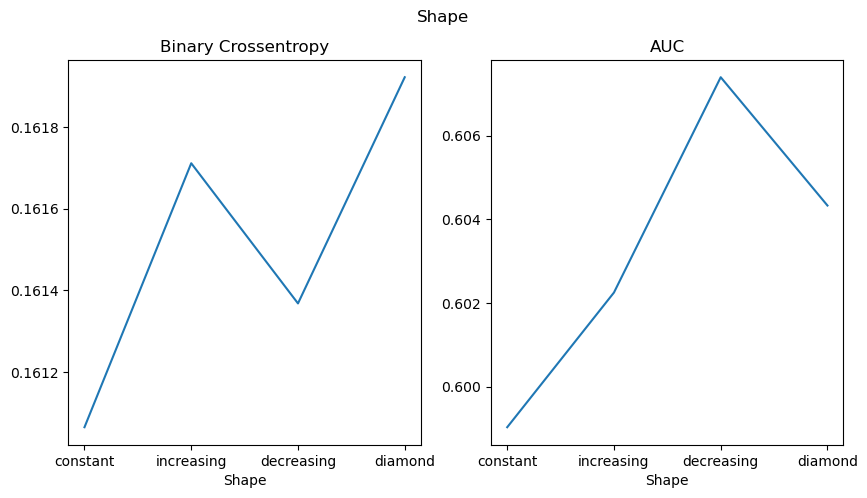

In [55]:
# Plot the minimum validation loss
summary_df = pd.DataFrame(index=np.arange(4),data={
    "binary_crossentropy":np.zeros(4,dtype=float),
    "auc":np.zeros(4,dtype=float)
})

shape_names = list(shapes.keys())

for neurons in range(4):
    df = pd.read_csv(f'logs/shape_{shape_names[neurons]}.csv')
    binary_crossentropy = df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]
    auc = df[df.val_loss == df.val_loss.min()].auc.values[0]
    summary_df.loc[neurons,['binary_crossentropy']] = binary_crossentropy
    summary_df.loc[neurons,['auc']] = auc


# Plot the result
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.suptitle("Shape")
ax[0].set_title('Binary Crossentropy')
ax[0].set_xlabel('Shape')
ax[0].plot(summary_df.index,summary_df.binary_crossentropy)
ax[0].set_xticks(summary_df.index,shape_names)

ax[1].set_title('AUC')
ax[1].set_xlabel('Shape')
ax[1].plot(summary_df.index,summary_df.auc)
ax[1].set_xticks(summary_df.index,shape_names)

plt.show()